In [1]:
# To display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import requests
import json
import time
from bech32 import bech32_encode, convertbits

from datetime import datetime
from tqdm import tqdm
from bech32 import bech32_decode, convertbits
from binascii import hexlify

In [3]:
pd.options.display.float_format = "{:.6f}".format

In [4]:
def bech32_to_hex(addr_bech32: str) -> str:
    hrp, data = bech32_decode(addr_bech32)
    if data is None:
        raise ValueError(f"Invalid bech32 address: {addr_bech32}")
    decoded = convertbits(data, 5, 8, False)
    return hexlify(bytes(decoded)).decode()

def safe_bech32_to_hex(addr):
    if pd.isna(addr):
        return None
    try:
        return bech32_to_hex(addr)
    except Exception:
        return None

def hex_to_bech32(addr_hex: str, hrp="addr") -> str:
    """Convert 128-char hex string to bech32 address."""
    data = bytes.fromhex(addr_hex)
    five_bit = convertbits(data, 8, 5)
    return bech32_encode(hrp, five_bit)


def safe_hex_to_bech32(addr_hex: str, hrp="addr") -> str:
    """Convert 128-char hex string to bech32 address with error handling."""
    try:
        data = bytes.fromhex(addr_hex)
        five_bit = convertbits(data, 8, 5)
        return bech32_encode(hrp, five_bit)
    except Exception as e:
        return None  

In [5]:
path = "/home/jovyan/work/New Topic/wrt_aggregated_holder_df_revised.csv"
wrt_aggregated_holder_df = pd.read_csv(path)
wrt_aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_wrt,sent_sum_wrt,wrt_balance,ada_balance,received_token_units,sent_token_units,asset_ids,script,received_token_count,sent_token_count,token_num,is_virtual,all_bech32_addresses,has_script_address
0,holder::addr1qydypcg5n7tkdpyvhag832wg5zasdlp5p...,943,4121.318116,1211.400000,1.000000,0.000000,1.000000,2909.918116,['007394e3117755fbb0558b93c54ce3bc6c8577092004...,[],['007394e3117755fbb0558b93c54ce3bc6c8577092004...,False,168,0,168,True,['addr1qydypcg5n7tkdpyvhag832wg5zasdlp5pf3fd7s...,False
1,holder::addr1v80rc443e7kdya5epx90grwapc0h8cdxp...,113,17743.052489,17724.161759,1.000000,0.000000,1.000000,18.890730,['15642bb40962b79700c693ecff664af0ebfa154af884...,['ec2e4e396fd178c1d44831a1f15efc86d1fa81c5396b...,['15642bb40962b79700c693ecff664af0ebfa154af884...,False,154,2,152,True,['addr1v80rc443e7kdya5epx90grwapc0h8cdxp9wd6hy...,False
2,holder::addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkf...,43246,731511685.127116,731222757.137427,3352.000000,3350.000000,2.000000,333928.012310,['000ffeb007da43324aefe044555fbe5bc469c38aa506...,['000ffeb007da43324aefe044555fbe5bc469c38aa506...,['000ffeb007da43324aefe044555fbe5bc469c38aa506...,False,168,167,168,True,['addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkfvf5xv8...,False
3,holder::addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5...,8,73.204240,0.000000,2.000000,0.000000,2.000000,73.204240,['000dbe0b66e9ceb8357eeb7eacbdc6e2707345924ba8...,[],['000dbe0b66e9ceb8357eeb7eacbdc6e2707345924ba8...,False,155,0,155,True,['addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5hmtp8v...,False
4,holder::addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnsch...,1,1.060260,0.000000,1975.000000,0.000000,1975.000000,1.060260,['c0ee29a85b13209423b10447d3c2e6a50641a15c5777...,[],['c0ee29a85b13209423b10447d3c2e6a50641a15c5777...,False,1,0,1,True,['addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnschjju707...,False


In [6]:
# Drop the list columns that are no longer needed
cols_to_drop = ["received_token_units", "sent_token_units", "asset_ids", "script"]
wrt_aggregated_holder_df = wrt_aggregated_holder_df.drop(columns=[c for c in cols_to_drop if c in wrt_aggregated_holder_df.columns])

# Preview result
wrt_aggregated_holder_df.head()


,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_wrt,sent_sum_wrt,wrt_balance,ada_balance,received_token_count,sent_token_count,token_num,is_virtual,all_bech32_addresses,has_script_address
0,holder::addr1qydypcg5n7tkdpyvhag832wg5zasdlp5p...,943,4121.318116,1211.400000,1.000000,0.000000,1.000000,2909.918116,168,0,168,True,['addr1qydypcg5n7tkdpyvhag832wg5zasdlp5pf3fd7s...,False
1,holder::addr1v80rc443e7kdya5epx90grwapc0h8cdxp...,113,17743.052489,17724.161759,1.000000,0.000000,1.000000,18.890730,154,2,152,True,['addr1v80rc443e7kdya5epx90grwapc0h8cdxp9wd6hy...,False
2,holder::addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkf...,43246,731511685.127116,731222757.137427,3352.000000,3350.000000,2.000000,333928.012310,168,167,168,True,['addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkfvf5xv8...,False
3,holder::addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5...,8,73.204240,0.000000,2.000000,0.000000,2.000000,73.204240,155,0,155,True,['addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5hmtp8v...,False
4,holder::addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnsch...,1,1.060260,0.000000,1975.000000,0.000000,1975.000000,1.060260,1,0,1,True,['addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnschjju707...,False


# Data Cleaning

In [7]:
print(wrt_aggregated_holder_df["has_script_address"].value_counts())

has_script_address
False    9102
True      321
Name: count, dtype: int64


In [8]:
num_low_wrt = (wrt_aggregated_holder_df["wrt_balance"] < 1).sum()
print(f"📉 Number of holders with wrt_balance < 1: {num_low_wrt}")

📉 Number of holders with wrt_balance < 1: 3


In [9]:
# Count missing values per column
missing_counts = wrt_aggregated_holder_df.isnull().sum()

# Only show columns that have missing values
missing_counts = missing_counts[missing_counts > 0]

# Show result
if missing_counts.empty:
    print("✅ No missing values found in any column.")
else:
    print("⚠️ Missing values detected:")
    print(missing_counts)


✅ No missing values found in any column.


In [10]:
import ast  # Safely convert string to list

# Step 1: Remove rows where wrt_balance < 1
filtered_df = wrt_aggregated_holder_df[wrt_aggregated_holder_df["wrt_balance"] >= 1].copy()

# Step 2: Remove rows with any script address
filtered_df = filtered_df[filtered_df["has_script_address"] == False]

# Step 3: Exclude rows where any address in all_bech32_addresses is in exclusion list
exclusion_list = set([
    "addr1wypr0np3xatwhddulsnj3aaac65qg768zgs2xpd2xuaj0zscmvh0n",
    "addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3dlszhqcllwkvdsx343mwz43dgq9gaxg7ah3zzrrfr76rxqy3wxcqeapnzx",
    "addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p56496x9f7g940jft",
    "addr1w8qnfkpe5e99m7umz4vxnmelxs5qw5dxytmfjk964rla98q605wte",
    "addr1z8nvjzjeydcn4atcd93aac8allvrpjn7pjr2qsweukpnaytvcg6zm2vds6mz9x3h3yalqmnf24w86m09n40q3tgqxjms9yu6v8",
    "addr1x8pydstdswmdqmg2rdt59dzql3zgfp9pt8sulnjgalycwdssxdwtkts49uw77gv6ck8st7qtfkq52ph08ywgn8p9h8csn2vzgr",
    "addr1w8pydstdswmdqmg2rdt59dzql3zgfp9pt8sulnjgalycwdsj9js7w",
    "addr1w85cy0pdjmlu9xaxm454lkzl0p92pqdaesqlj2a5xfpww5s7evt7c",
    "addr1q8r4d9xfsj4xqz9uty275skk6jvckjuvz3wrjcwkld4t86kyq0shvpqyac96w2h64qe7gngvv4hw5tt3ytztgtxcxdeqwk349u",
    "addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnjl9ph20rpxjxxg2ljjn7prtanxktqg0vnrcstn38cccf5fq5tghsqvl0dq",
    "addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdluet0037jyhckm3y40uh68rvjwtap89s7pqkfw2z65fu97m624fe4seq346u",
    "addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6fanezx402a20lzdd0zjfg0xzl3fn3hjryk0cm9elz5x8qkf2gsstfac8t"
])

# Function to safely convert to list and check exclusion
def contains_excluded_address(address_str):
    try:
        address_list = ast.literal_eval(address_str)
        return any(addr in exclusion_list for addr in address_list)
    except Exception:
        return False  # If parsing fails, assume not excluded

filtered_df = filtered_df[~filtered_df["all_bech32_addresses"].apply(contains_excluded_address)]

# Overwrite original df
wrt_aggregated_holder_df = filtered_df

# Report final shape
print(f"✅ Final cleaned wrt_aggregated_holder_df shape: {wrt_aggregated_holder_df.shape}")


✅ Final cleaned wrt_aggregated_holder_df shape: (9097, 14)


# EDA


In [11]:
wrt_aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_wrt,sent_sum_wrt,wrt_balance,ada_balance,received_token_count,sent_token_count,token_num,is_virtual,all_bech32_addresses,has_script_address
0,holder::addr1qydypcg5n7tkdpyvhag832wg5zasdlp5p...,943,4121.318116,1211.400000,1.000000,0.000000,1.000000,2909.918116,168,0,168,True,['addr1qydypcg5n7tkdpyvhag832wg5zasdlp5pf3fd7s...,False
1,holder::addr1v80rc443e7kdya5epx90grwapc0h8cdxp...,113,17743.052489,17724.161759,1.000000,0.000000,1.000000,18.890730,154,2,152,True,['addr1v80rc443e7kdya5epx90grwapc0h8cdxp9wd6hy...,False
2,holder::addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkf...,43246,731511685.127116,731222757.137427,3352.000000,3350.000000,2.000000,333928.012310,168,167,168,True,['addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkfvf5xv8...,False
3,holder::addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5...,8,73.204240,0.000000,2.000000,0.000000,2.000000,73.204240,155,0,155,True,['addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5hmtp8v...,False
4,holder::addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnsch...,1,1.060260,0.000000,1975.000000,0.000000,1975.000000,1.060260,1,0,1,True,['addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnschjju707...,False


In [12]:
# Step 1: Sort the DataFrame by WRT balance in descending order
top_10_holders = wrt_aggregated_holder_df.sort_values(by="wrt_balance", ascending=False).head(10)

# Step 2: Display top 10 holders with their WRT balances and associated addresses
print("💰 Top 10 WRT Holders by Balance:\n")
print(top_10_holders[["all_bech32_addresses", "wrt_balance"]].to_string(index=False))


💰 Top 10 WRT Holders by Balance:

                                                                                       all_bech32_addresses    wrt_balance
['addr1q8w3amqje077s8vwrzvy9qgfuj9s77shdlz8j6h8xea0x2uqx236903qpv4g2ngagrthw4q0s0kr3gr9cnj7ygzay2jq0us3hj'] 2249963.845241
['addr1qxanpvy0369alsd74930yyh3pr72yv8qykw7jx48rzygx74zs9da8rkttujlp7gkfwzuxru53t7r9gfmjnzv3wpxd5tsaswevv'] 1369642.857013
['addr1qyf569gwulcfgw0jdjnla2m9tdunzv4autplntv8yd65l79jlu6r57wrsdlx4dwxvx3r0yw39tapp54qxuyxlpgdrv8q3vqm2k'] 1208333.333333
['addr1q8lj38mvr0la7g8erh6kcdkyyz9dyy0cms99as0ww7c3u9faqdtuuznsetmrqvkt3umj9uu0wpqmxuxy4y056tdaka0sd2wgle'] 1196684.364809
['addr1qywls0fquzmv63fp9qw3458pqes6d5v0wt9h9swhk6w2xer8xccxzp6y2fm37wueygkfy4m4yla997yv4redyzd9kyvs88nzaw']  820186.100125
['addr1q9xc480ha4xzas6cer0qjeh8x3sa0tjlh083xskkqu556rxlh2k969pw3vjd094h2jpa0n9g27yxkyargjvgl0wmskpqkzzt27']  805413.823055
['addr1qy5n23mf4fzaj4l3j8vkd9789n0lfzlg8pa7vzjymzurwhg7q5mclvnem7qlkut29fmx0dk7xz48ze2yel4hthpd0pms72ch0q

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='wrt_balance', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of WRT Balance')

Text(0.5, 0, 'WRT Balance')

Text(0, 0.5, 'Frequency')

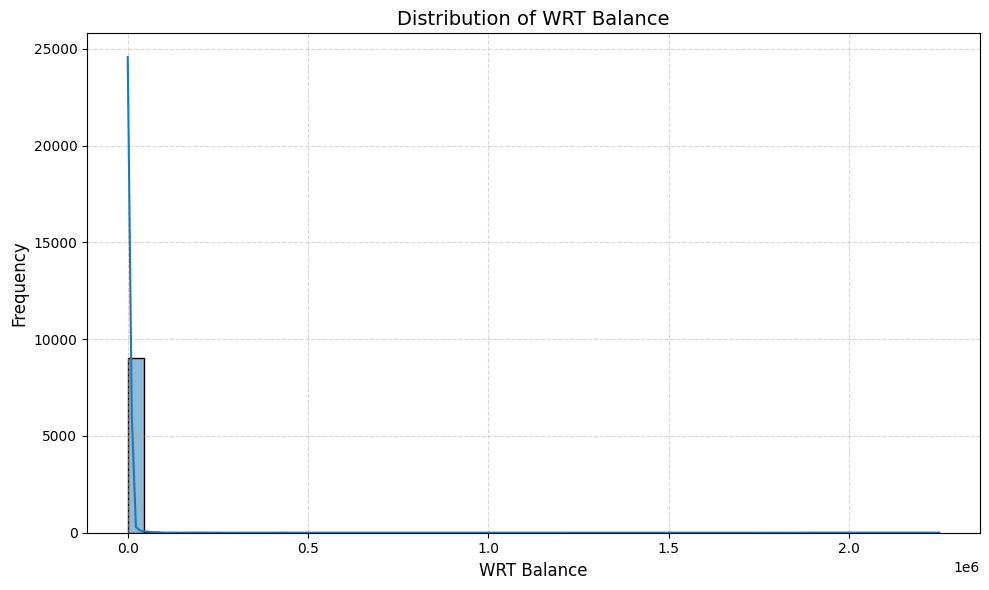

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Plot histogram for WRT balance ===
plt.figure(figsize=(10, 6))

# Histogram with KDE curve
sns.histplot(wrt_aggregated_holder_df["wrt_balance"], bins=50, kde=True)

# Title and labels
plt.title("Distribution of WRT Balance", fontsize=14)
plt.xlabel("WRT Balance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
wrt_aggregated_holder_df["wrt_balance"].describe()

count      9097.000000
mean       2669.428084
std       39669.598212
min           1.000000
25%           2.000000
50%          10.000000
75%          89.444515
max     2249963.845241
Name: wrt_balance, dtype: float64

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Lorenz Curve for WRT Balance\nGini Coefficient = 0.977')

Text(0.5, 0, 'Cumulative Share of Addresses')

Text(0, 0.5, 'Cumulative Share of WRT')

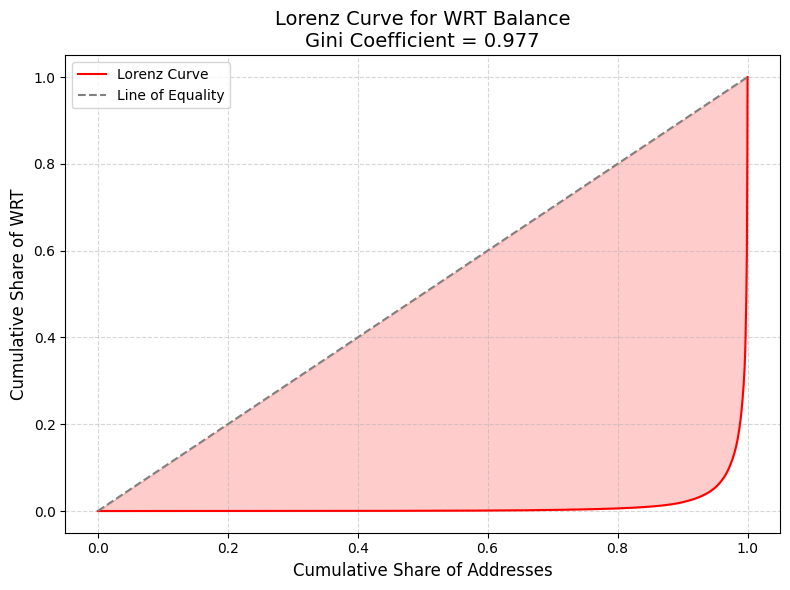

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Sort WRT balances in ascending order ===
balances = wrt_aggregated_holder_df["wrt_balance"].sort_values().values
n = len(balances)
cum_balances = np.cumsum(balances)
lorenz_curve = np.insert(cum_balances / cum_balances[-1], 0, 0)  # Normalize and add 0

# === Step 2: Gini calculation ===
x = np.linspace(0.0, 1.0, n+1)
gini_index = 1 - 2 * np.trapz(lorenz_curve, x)

# === Step 3: Plot Lorenz curve ===
plt.figure(figsize=(8, 6))
plt.plot(x, lorenz_curve, label="Lorenz Curve", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Line of Equality")
plt.fill_between(x, lorenz_curve, x, color="red", alpha=0.2)

plt.title(f"Lorenz Curve for WRT Balance\nGini Coefficient = {gini_index:.3f}", fontsize=14)
plt.xlabel("Cumulative Share of Addresses", fontsize=12)
plt.ylabel("Cumulative Share of WRT", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Cumulative Token Share by Top Holders')

Text(0.5, 0, 'Top k Addresses')

Text(0, 0.5, 'Cumulative Share of WRT')

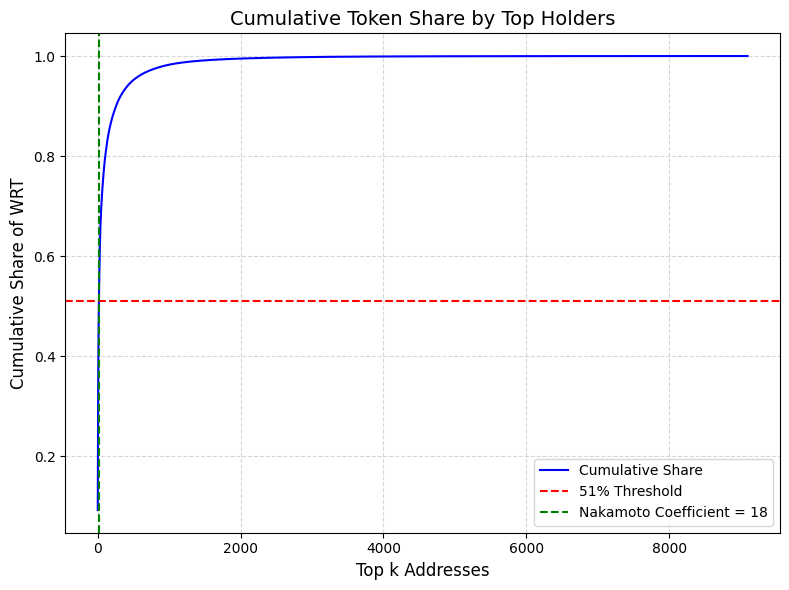

In [16]:
# === Step 1: Sort balances in descending order and normalize ===
sorted_balances = wrt_aggregated_holder_df["wrt_balance"].sort_values(ascending=False).values
total = sorted_balances.sum()
shares = sorted_balances / total
cumulative_share = np.cumsum(shares)

# === Step 2: Find minimum k such that cumulative share ≥ 0.51
nakamoto_k = np.argmax(cumulative_share >= 0.51) + 1

# === Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(shares) + 1), cumulative_share, label="Cumulative Share", color="blue")
plt.axhline(0.51, linestyle="--", color="red", label="51% Threshold")
plt.axvline(nakamoto_k, linestyle="--", color="green", label=f"Nakamoto Coefficient = {nakamoto_k}")

plt.title("Cumulative Token Share by Top Holders", fontsize=14)
plt.xlabel("Top k Addresses", fontsize=12)
plt.ylabel("Cumulative Share of WRT", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Token Distribution: Lorenz Curve & Nakamoto Coefficient')

Text(0.5, 0, 'Cumulative Share of Addresses')

Text(0, 0.5, 'Cumulative Share of WRT')

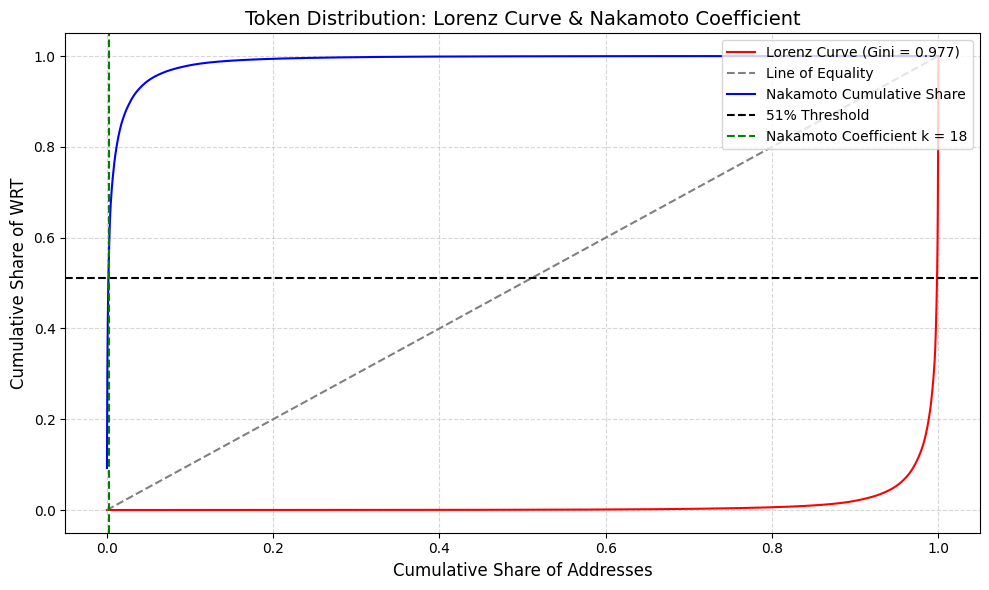

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Lorenz Curve (Gini) ===
balances = wrt_aggregated_holder_df["wrt_balance"].sort_values().values
n = len(balances)
cum_balances = np.cumsum(balances)
lorenz_curve = np.insert(cum_balances / cum_balances[-1], 0, 0)
x_lorenz = np.linspace(0.0, 1.0, n + 1)
gini_index = 1 - 2 * np.trapz(lorenz_curve, x_lorenz)

# === Step 2: Nakamoto Coefficient ===
sorted_balances_desc = wrt_aggregated_holder_df["wrt_balance"].sort_values(ascending=False).values
total = sorted_balances_desc.sum()
shares = sorted_balances_desc / total
cumulative_share = np.cumsum(shares)
x_nakamoto = np.arange(1, len(shares) + 1)
nakamoto_k = np.argmax(cumulative_share >= 0.51) + 1

# === Step 3: Plot combined figure ===
plt.figure(figsize=(10, 6))

# Lorenz curve
plt.plot(x_lorenz, lorenz_curve, label=f"Lorenz Curve (Gini = {gini_index:.3f})", color="red")

# Line of equality
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Line of Equality")

# Nakamoto cumulative
plt.plot(x_nakamoto / len(shares), cumulative_share, label="Nakamoto Cumulative Share", color="blue")

# Thresholds
plt.axhline(0.51, linestyle="--", color="black", label="51% Threshold")
plt.axvline(nakamoto_k / len(shares), linestyle="--", color="green", label=f"Nakamoto Coefficient k = {nakamoto_k}")

# Titles & labels
plt.title("Token Distribution: Lorenz Curve & Nakamoto Coefficient", fontsize=14)
plt.xlabel("Cumulative Share of Addresses", fontsize=12)
plt.ylabel("Cumulative Share of WRT", fontsize=12)

# Updated legend position
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [18]:
import numpy as np

# Step 1: Sort by WRT balance in descending order
sorted_wrt = wrt_aggregated_holder_df.sort_values(by="wrt_balance", ascending=False)

# Step 2: Compute WRT share per address
total_wrt = sorted_wrt["wrt_balance"].sum()
sorted_wrt["wrt_share"] = sorted_wrt["wrt_balance"] / total_wrt

# Step 3: Compute cumulative share
sorted_wrt["cumulative_share"] = sorted_wrt["wrt_share"].cumsum()

# ✅ Step 4: Get true Nakamoto k (smallest number of top addresses reaching ≥ 51%)
nakamoto_k = (sorted_wrt["cumulative_share"] >= 0.51).values.argmax() + 1

print(f"🔐 Corrected Nakamoto coefficient k = {nakamoto_k}")


🔐 Corrected Nakamoto coefficient k = 18


In [19]:
# Sort by WRT balance in descending order
sorted_df = wrt_aggregated_holder_df.sort_values(by="wrt_balance", ascending=False)

# Get the top 100 holders
top_100_df = sorted_df.head(100)

# Calculate total WRT held by top 100
top_100_total = top_100_df["wrt_balance"].sum()

# Calculate total WRT in the dataset
total_wrt = wrt_aggregated_holder_df["wrt_balance"].sum()

# Calculate the percentage
top_100_share = top_100_total / total_wrt * 100

# Display the result
print(f"🔝 Top 100 holders hold {top_100_share:.2f}% of total WRT")


🔝 Top 100 holders hold 79.24% of total WRT


In [20]:
from pandas.api.types import CategoricalDtype

# Refined bin edges and ordered labels
bins = [1, 10, 50, 100, 500, 1_000, 10_000, 100_000, 1_000_000, float('inf')]
labels = ['1–10', '10–50', '50–100', '100–500', '500–1k', '1k–10k', '10k–100k', '100k–1M', '≥1M']

# Define ordered category
ordered_cat = CategoricalDtype(categories=labels, ordered=True)

# Assign tier to each address
wrt_aggregated_holder_df["wrt_tier"] = pd.cut(
    wrt_aggregated_holder_df["wrt_balance"],
    bins=bins,
    labels=labels,
    right=False
).astype(ordered_cat)

# Aggregate data
distribution = wrt_aggregated_holder_df.groupby("wrt_tier").agg(
    address_count=("final_holder_id", "count"),
    total_wrt=("wrt_balance", "sum")
).reset_index()

# Compute shares
total_addresses = distribution["address_count"].sum()
total_wrt = distribution["total_wrt"].sum()
distribution["% of addresses"] = distribution["address_count"] / total_addresses * 100
distribution["% of total WRT"] = distribution["total_wrt"] / total_wrt * 100

# Format
distribution["total_wrt"] = distribution["total_wrt"].round(0).astype(int)
distribution["% of addresses"] = distribution["% of addresses"].round(2)
distribution["% of total WRT"] = distribution["% of total WRT"].round(2)

distribution


/tmp/ipykernel_3890/4129203741.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution = wrt_aggregated_holder_df.groupby("wrt_tier").agg(


,wrt_tier,address_count,total_wrt,% of addresses,% of total WRT
0,1–10,4473,13577,49.170000,0.060000
1,10–50,1739,39617,19.120000,0.160000
2,50–100,717,51326,7.880000,0.210000
3,100–500,1025,230059,11.270000,0.950000
4,500–1k,249,174141,2.740000,0.720000
5,1k–10k,650,2044358,7.150000,8.420000
6,10k–100k,206,5734246,2.260000,23.610000
7,100k–1M,34,9971839,0.370000,41.060000
8,≥1M,4,6024624,0.040000,24.810000


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='wrt_balance', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Holders with 1 to 1000 WRT')

Text(0.5, 0, 'WRT Balance')

Text(0, 0.5, 'Number of Holders')

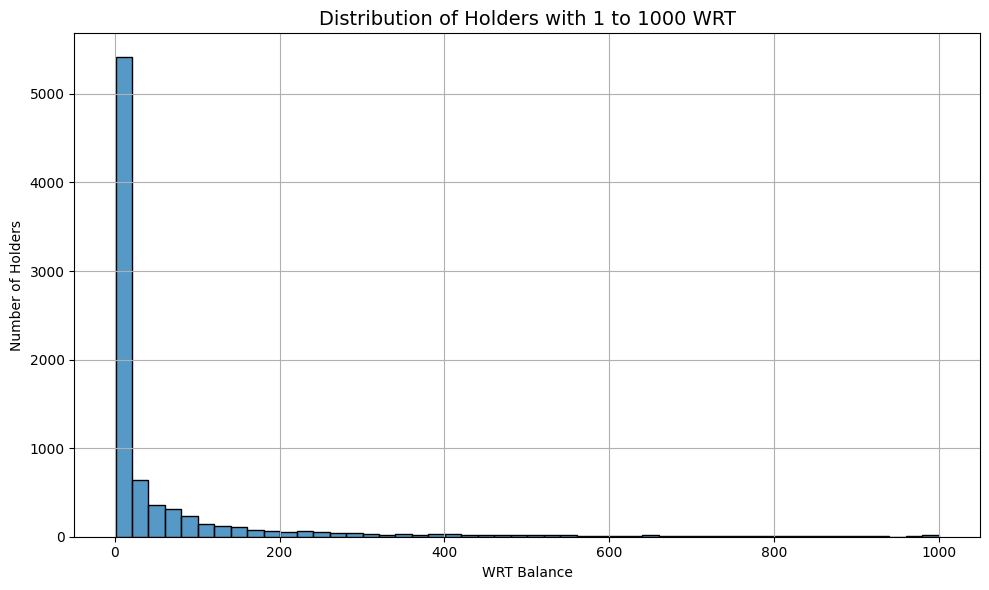

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter holders with 1 ≤ wrt_balance ≤ 1000
filtered = wrt_aggregated_holder_df[
    (wrt_aggregated_holder_df["wrt_balance"] >= 1) &
    (wrt_aggregated_holder_df["wrt_balance"] <= 1000)
]

# Step 2: Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered["wrt_balance"], bins=50, kde=False)
plt.title("Distribution of Holders with 1 to 1000 WRT", fontsize=14)
plt.xlabel("WRT Balance")
plt.ylabel("Number of Holders")
plt.grid(True)
plt.tight_layout()
plt.show()


# Deal With Skewness

In [22]:
wrt_aggregated_holder_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9097 entries, 0 to 9422
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   final_holder_id       9097 non-null   object  
 1   tx_count              9097 non-null   int64   
 2   received_sum_ada      9097 non-null   float64 
 3   sent_sum_ada          9097 non-null   float64 
 4   received_sum_wrt      9097 non-null   float64 
 5   sent_sum_wrt          9097 non-null   float64 
 6   wrt_balance           9097 non-null   float64 
 7   ada_balance           9097 non-null   float64 
 8   received_token_count  9097 non-null   int64   
 9   sent_token_count      9097 non-null   int64   
 10  token_num             9097 non-null   int64   
 11  is_virtual            9097 non-null   bool    
 12  all_bech32_addresses  9097 non-null   object  
 13  has_script_address    9097 non-null   bool    
 14  wrt_tier              9097 non-null   category
dtypes: bool(2

<Axes: xlabel='tx_count', ylabel='Count'>

Text(0.5, 1.0, 'tx_count\nSkew: 26.72')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_ada', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_ada\nSkew: 64.66')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_sum_ada', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_ada\nSkew: 64.76')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_wrt', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_wrt\nSkew: 91.74')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_sum_wrt', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_wrt\nSkew: 91.77')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='wrt_balance', ylabel='Count'>

Text(0.5, 1.0, 'wrt_balance\nSkew: 34.92')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='ada_balance', ylabel='Count'>

Text(0.5, 1.0, 'ada_balance\nSkew: 82.07')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_token_count', ylabel='Count'>

Text(0.5, 1.0, 'received_token_count\nSkew: 67.29')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_token_count', ylabel='Count'>

Text(0.5, 1.0, 'sent_token_count\nSkew: 8.43')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='token_num', ylabel='Count'>

Text(0.5, 1.0, 'token_num\nSkew: 75.77')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.02, 'Distribution of Numeric Variables with Skewness')

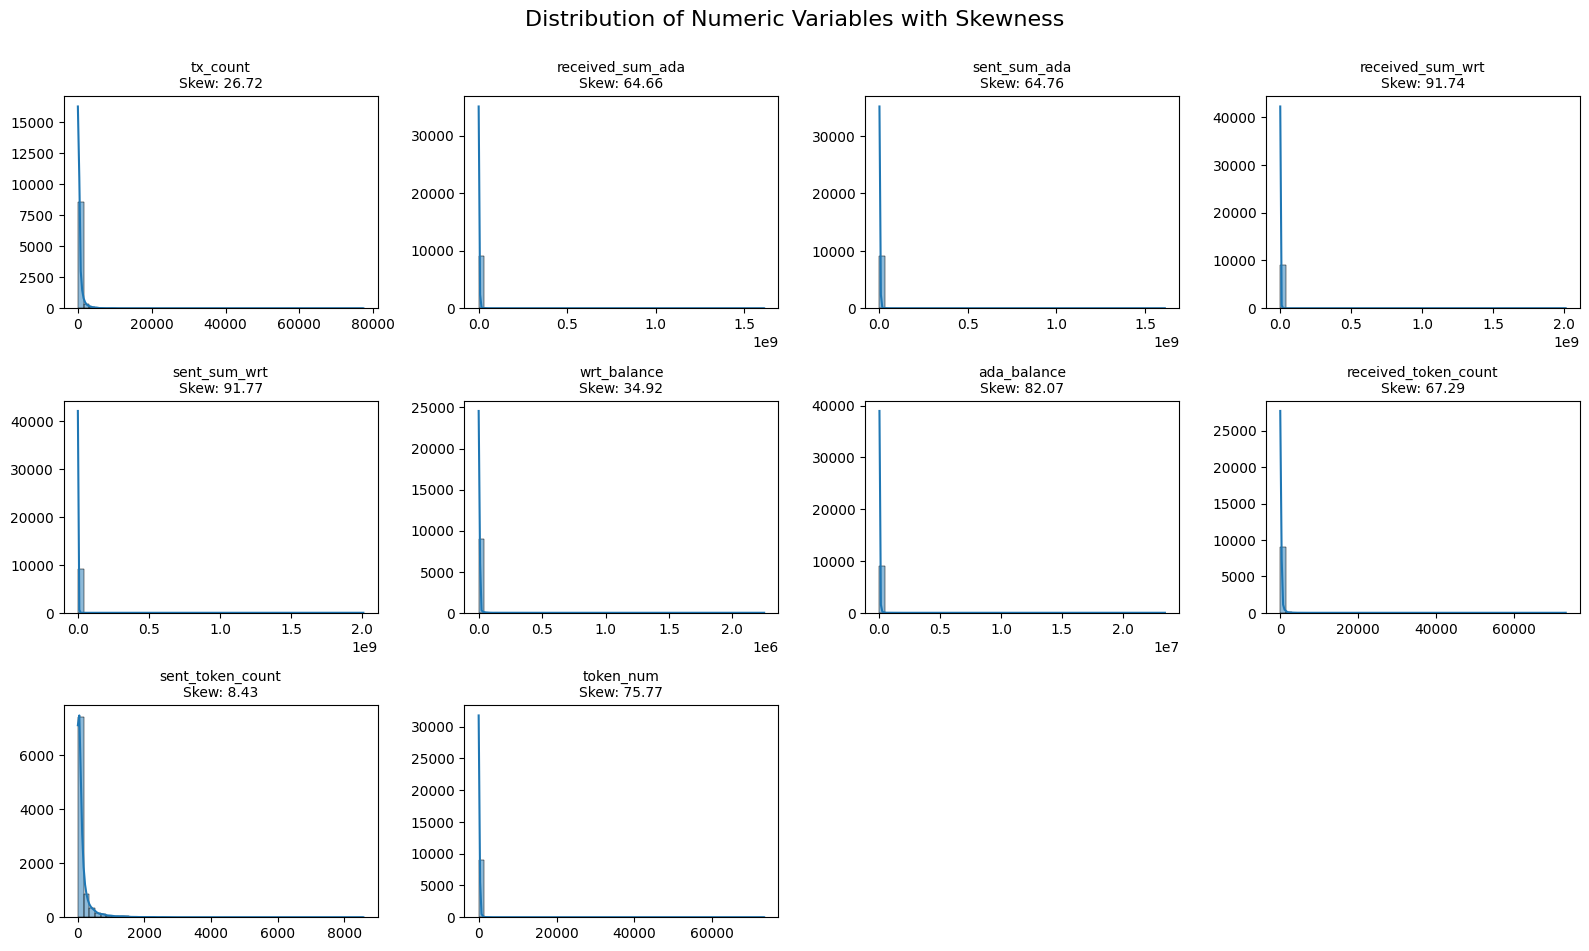

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Step 1: Get numeric columns (excluding addresses)
exclude_cols = [
    "final_holder_id", "hex_address", "is_virtual", "bech32_address", "all_bech32_addresses", "has_script_address", "wrt_tier"]
numeric_cols = [col for col in wrt_aggregated_holder_df.columns if col not in exclude_cols]

# Step 2: Compute skewness safely
skewness_values = {}
for col in numeric_cols:
    try:
        skewness_values[col] = skew(wrt_aggregated_holder_df[col].dropna())
    except Exception as e:
        print(f"⚠️ Skewness failed for {col}: {e}")
        skewness_values[col] = None

# Step 3: Set up 6x4 subplot grid
num_plots = len(numeric_cols)
num_rows, num_cols = 6, 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()  # Make it 1D for easy indexing

# Step 4: Plot each histogram in its subplot
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    try:
        sns.histplot(wrt_aggregated_holder_df[col], bins=50, kde=True, ax=ax)
        ax.set_title(f"{col}\nSkew: {skewness_values[col]:.2f}", fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("")
    except Exception as e:
        ax.text(0.5, 0.5, f"Failed: {col}", ha='center', va='center')
        print(f"❌ Failed to plot {col}: {e}")

# Step 5: Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution of Numeric Variables with Skewness", fontsize=16, y=1.02)
plt.show()
plt.close()


In [24]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

# All highly-skewed variables (including the two counts)
highly_skewed_cols = [
    "sent_sum_wrt", "received_sum_wrt",
    "sent_sum_ada", "received_sum_ada",
    "token_num", "ada_balance",
    "tx_count", "wrt_balance",
    "received_token_count", "sent_token_count"
]

# Transform each column independently (safer/clearer)
for col in highly_skewed_cols:
    x = wrt_aggregated_holder_df[col].to_numpy(dtype=float)
    mask = np.isfinite(x)  # handle NaN/inf safely

    pt = PowerTransformer(method="yeo-johnson", standardize=False)
    x_out = np.full_like(x, np.nan, dtype=float)
    if mask.any():
        x_out[mask] = pt.fit_transform(x[mask].reshape(-1, 1)).ravel()

    wrt_aggregated_holder_df[f"{col}_yeojohnson"] = x_out


<Axes: xlabel='sent_sum_wrt_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_wrt_yeojohnson\nSkew: 0.21')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_wrt_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_wrt_yeojohnson\nSkew: 0.13')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_sum_ada_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_ada_yeojohnson\nSkew: -0.05')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_ada_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_ada_yeojohnson\nSkew: -0.02')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='token_num_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'token_num_yeojohnson\nSkew: 0.00')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='ada_balance_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'ada_balance_yeojohnson\nSkew: 0.08')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='tx_count_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'tx_count_yeojohnson\nSkew: -0.03')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='wrt_balance_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'wrt_balance_yeojohnson\nSkew: 0.24')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_token_count_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'received_token_count_yeojohnson\nSkew: 0.00')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_token_count_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'sent_token_count_yeojohnson\nSkew: -0.04')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.02, 'All Variables After Yeo–Johnson Transform (incl. counts)')

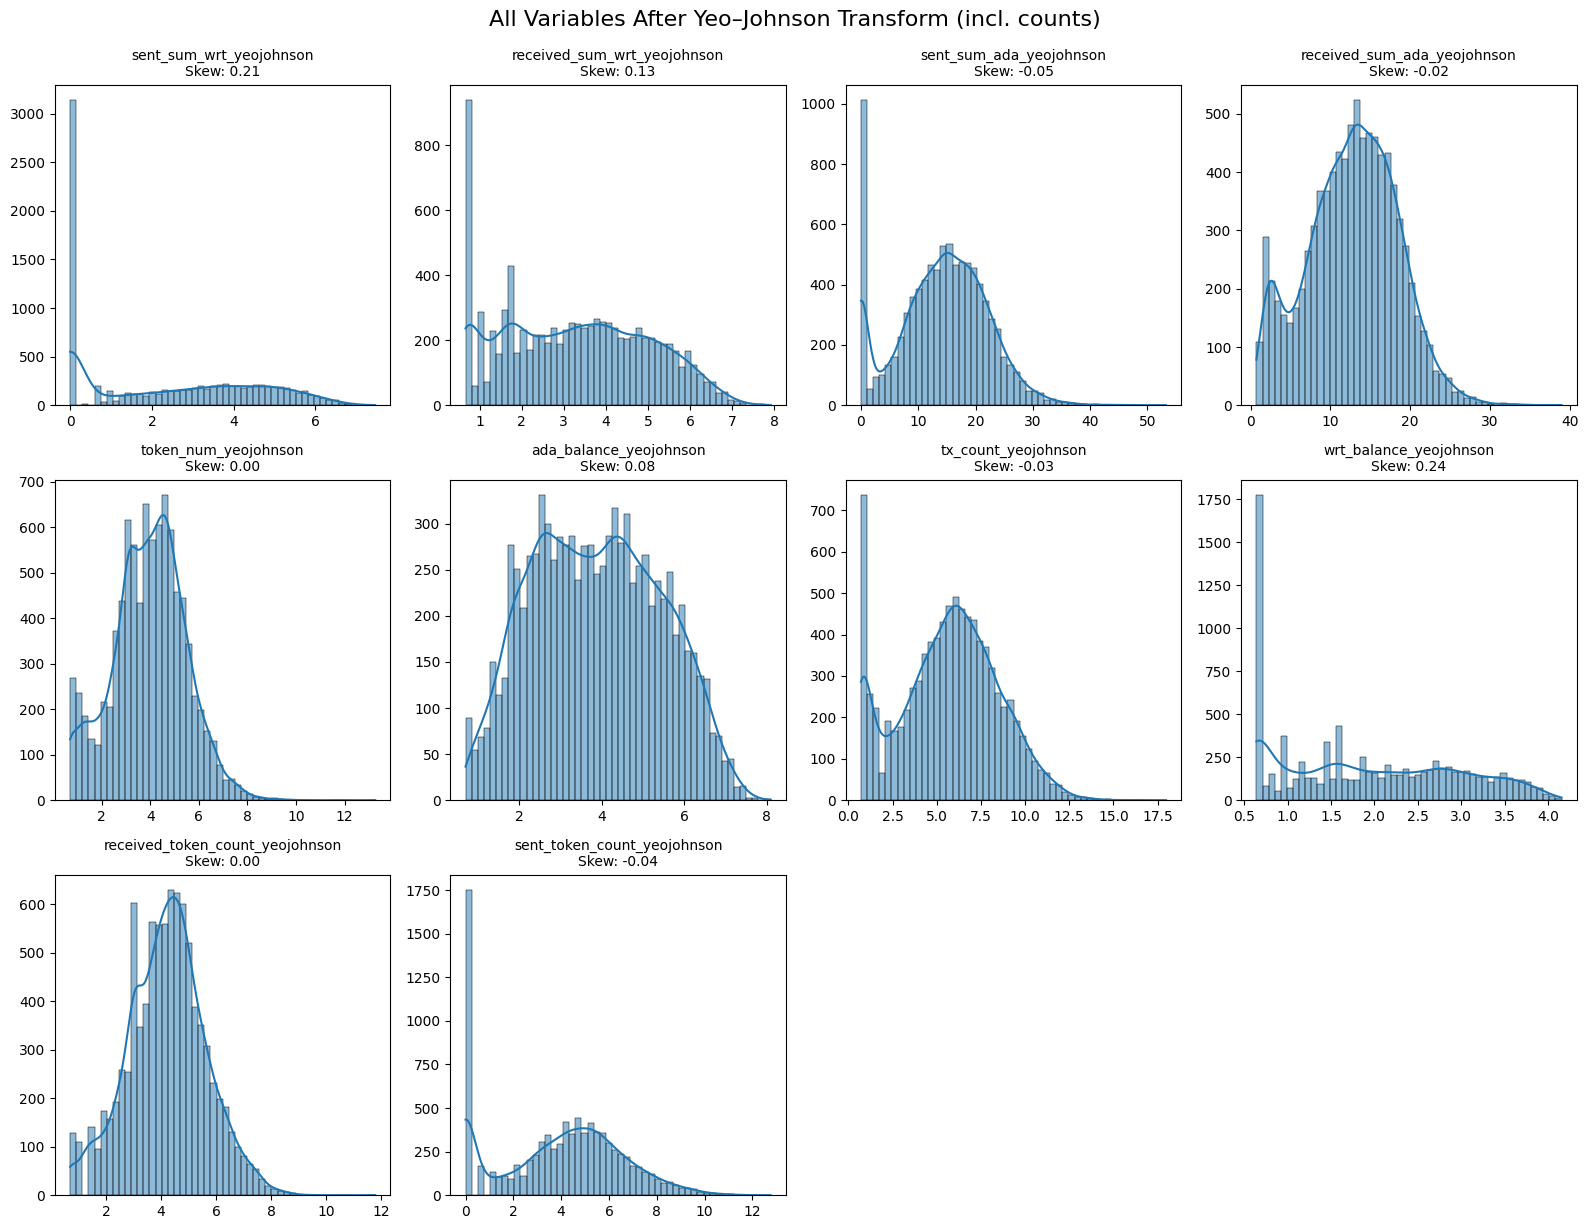

In [25]:
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

# Base variable names (original columns)
vars_base = [
    "sent_sum_wrt", "received_sum_wrt",
    "sent_sum_ada", "received_sum_ada",
    "token_num", "ada_balance",
    "tx_count", "wrt_balance",
    "received_token_count", "sent_token_count"
]

# Corresponding transformed columns
vars_yj = [f"{c}_yeojohnson" for c in vars_base]

# Check for available and non-empty columns
valid_vars = [c for c in vars_yj if c in wrt_aggregated_holder_df.columns and not wrt_aggregated_holder_df[c].dropna().empty]
if not valid_vars:
    print("❗ No valid variables to plot.")
else:
    # Compute skewness based on transformed data
    skewness_values = {}
    for col in valid_vars:
        try:
            skewness_values[col] = skew(wrt_aggregated_holder_df[col].dropna())
        except Exception as e:
            print(f"⚠️ Skewness failed for {col}: {e}")
            skewness_values[col] = None

    # Create subplots for histograms
    rows, cols = 3, 4
    fig2, axes2 = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 12))
    axes2 = axes2.flatten()

    # Plot each variable distribution
    for i, col in enumerate(valid_vars):
        ax = axes2[i]
        try:
            sns.histplot(wrt_aggregated_holder_df[col], bins=50, kde=True, ax=ax)
            sk = skewness_values.get(col)
            ax.set_title(f"{col}\nSkew: {sk:.2f}" if sk is not None else f"{col}\nSkew: N/A", fontsize=10)
            ax.set_xlabel("")
            ax.set_ylabel("")
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed: {col}", ha='center', va='center')
            print(f"❌ Failed to plot {col}: {e}")

    # Remove unused subplot axes
    for j in range(len(valid_vars), len(axes2)):
        fig2.delaxes(axes2[j])

    plt.tight_layout()
    plt.suptitle("All Variables After Yeo–Johnson Transform (incl. counts)", fontsize=16, y=1.02)
    plt.show()


In [26]:
features = [
    "sent_sum_wrt_yeojohnson", "received_sum_wrt_yeojohnson",
    "sent_sum_ada_yeojohnson", "received_sum_ada_yeojohnson",
    "ada_balance_yeojohnson", "token_num_yeojohnson",
    "tx_count_yeojohnson", "wrt_balance_yeojohnson",
    "received_token_count_yeojohnson", "sent_token_count_yeojohnson"
]


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Between Features')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'sent_sum_wrt_yeojohnson'),
  Text(1.5, 0, 'received_sum_wrt_yeojohnson'),
  Text(2.5, 0, 'sent_sum_ada_yeojohnson'),
  Text(3.5, 0, 'received_sum_ada_yeojohnson'),
  Text(4.5, 0, 'ada_balance_yeojohnson'),
  Text(5.5, 0, 'token_num_yeojohnson'),
  Text(6.5, 0, 'tx_count_yeojohnson'),
  Text(7.5, 0, 'wrt_balance_yeojohnson'),
  Text(8.5, 0, 'received_token_count_yeojohnson'),
  Text(9.5, 0, 'sent_token_count_yeojohnson')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'sent_sum_wrt_yeojohnson'),
  Text(0, 1.5, 'received_sum_wrt_yeojohnson'),
  Text(0, 2.5, 'sent_sum_ada_yeojohnson'),
  Text(0, 3.5, 'received_sum_ada_yeojohnson'),
  Text(0, 4.5, 'ada_balance_yeojohnson'),
  Text(0, 5.5, 'token_num_yeojohnson'),
  Text(0, 6.5, 'tx_count_yeojohnson'),
  Text(0, 7.5, 'wrt_balance_yeojohnson'),
  Text(0, 8.5, 'received_token_count_yeojohnson'),
  Text(0, 9.5, 'sent_token_count_yeojohnson')])

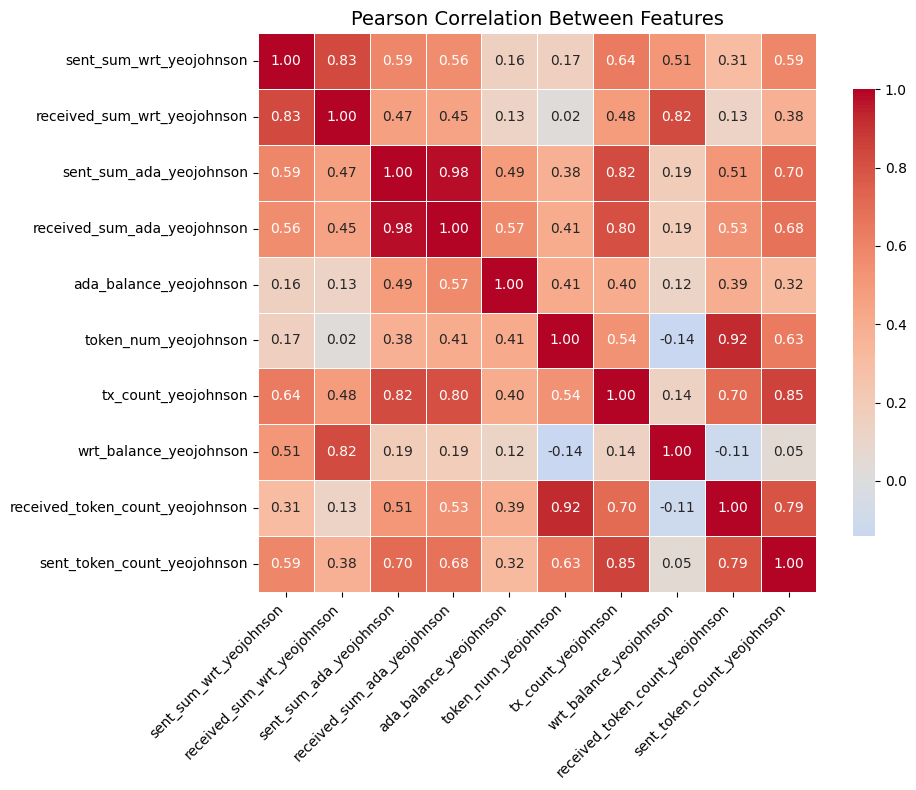

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = wrt_aggregated_holder_df[features].corr(method='pearson')


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

plt.title("Pearson Correlation Between Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [28]:
features = [
    "ada_balance_yeojohnson", "token_num_yeojohnson",
    "tx_count_yeojohnson", "wrt_balance_yeojohnson",
]


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Between Features')

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'ada_balance_yeojohnson'),
  Text(1.5, 0, 'token_num_yeojohnson'),
  Text(2.5, 0, 'tx_count_yeojohnson'),
  Text(3.5, 0, 'wrt_balance_yeojohnson')])

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'ada_balance_yeojohnson'),
  Text(0, 1.5, 'token_num_yeojohnson'),
  Text(0, 2.5, 'tx_count_yeojohnson'),
  Text(0, 3.5, 'wrt_balance_yeojohnson')])

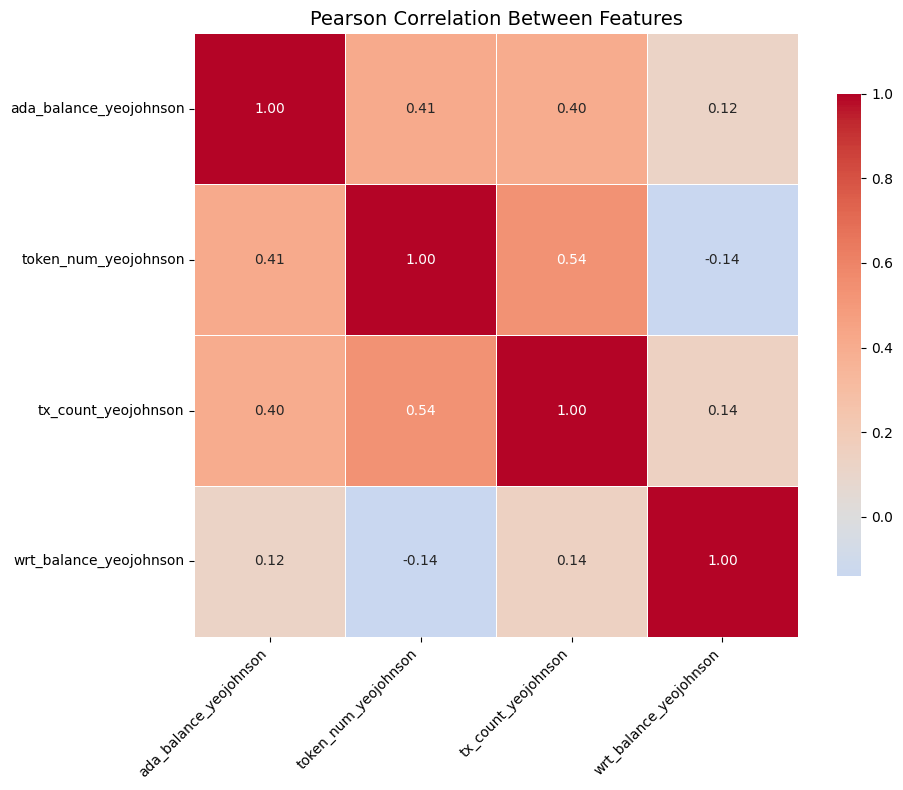

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = wrt_aggregated_holder_df[features].corr(method='pearson')


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

plt.title("Pearson Correlation Between Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# K-Means Clustering

Text(0.5, 1.0, 'Elbow Method (Inertia vs. k)')

Text(0.5, 0, 'Number of Clusters (k)')

Text(0, 0.5, 'Inertia')

Text(0.5, 1.0, 'Silhouette Score vs. k')

Text(0.5, 0, 'Number of Clusters (k)')

Text(0, 0.5, 'Silhouette Score')

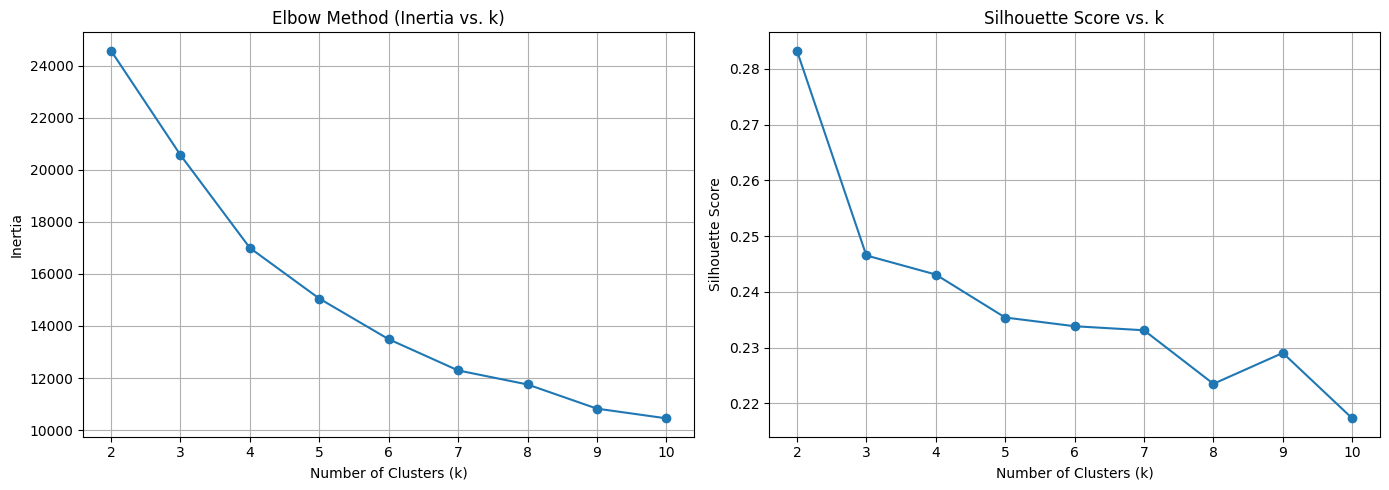

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Extract and standardize the selected features
X = wrt_aggregated_holder_df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Initialize result containers
inertias = []
silhouette_scores = []
k_range = range(2, 11)  # Try k from 2 to 10

# Step 3: Loop over possible k values to evaluate clustering quality
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)

    # Inertia measures how compact the clusters are (lower = better)
    inertias.append(kmeans.inertia_)

    # Silhouette score measures how well clusters are separated (higher = better)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Step 4: Plot Elbow and Silhouette charts side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Plot: Inertia vs. k
ax1.plot(k_range, inertias, marker='o')
ax1.set_title("Elbow Method (Inertia vs. k)")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.grid(True)

# Silhouette Plot: Silhouette Score vs. k
ax2.plot(k_range, silhouette_scores, marker='o')
ax2.set_title("Silhouette Score vs. k")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.grid(True)

plt.tight_layout()
plt.show()


In [31]:
from sklearn.cluster import KMeans

# Step 1: Fit KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(X_scaled)

# Step 2: Save cluster labels into the dataframe
wrt_aggregated_holder_df["kmeans_cluster"] = kmeans_labels

# Step 3: Print cluster size counts
print(wrt_aggregated_holder_df["kmeans_cluster"].value_counts().sort_index())


kmeans_cluster
0    2671
1    1546
2    2307
3    2573
Name: count, dtype: int64


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

Text(0.5, 1.0, 't-SNE Visualization of KMeans Clusters (4D Features)')

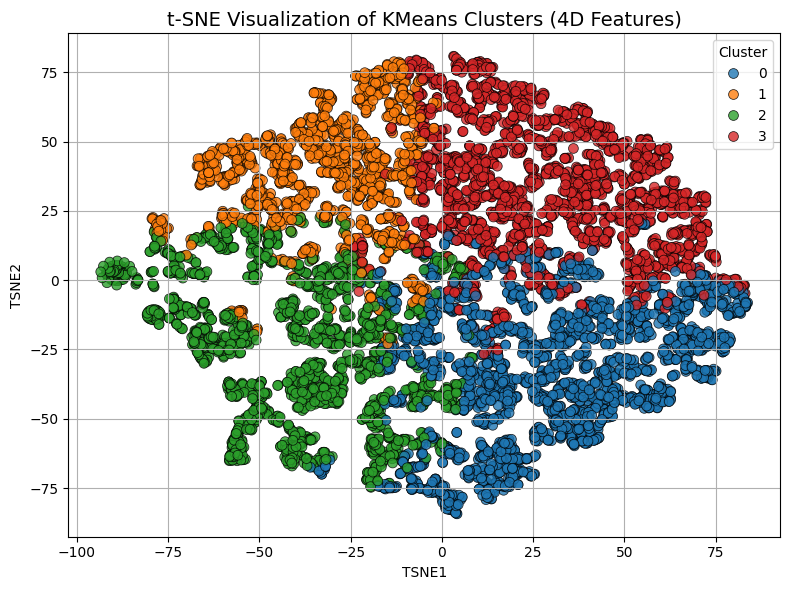

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Run t-SNE on standardized features
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Step 2: Create a DataFrame for visualization
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["cluster"] = kmeans_labels  # make sure this is from k=4

# Step 3: Plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1", y="TSNE2",
    hue="cluster",
    palette="tab10",
    s=50,
    edgecolor="k",
    alpha=0.8
)
plt.title("t-SNE Visualization of KMeans Clusters (4D Features)", fontsize=14)
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()



In [33]:
cluster_summary = wrt_aggregated_holder_df.groupby("kmeans_cluster")[features].mean().round(2)
cluster_summary


,ada_balance_yeojohnson,token_num_yeojohnson,tx_count_yeojohnson,wrt_balance_yeojohnson
kmeans_cluster,,,,
0,4.450000,4.920000,7.300000,1.100000
1,2.750000,2.060000,4.290000,2.840000
2,2.720000,3.380000,2.760000,1.220000
3,4.980000,4.620000,7.360000,2.910000


Text(0.5, 1.0, 'Radar Chart of KMeans Clusters')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, 'ada_balance_yeojohnson'),
  Text(1.5707963267948966, 0, 'token_num_yeojohnson'),
  Text(3.141592653589793, 0, 'tx_count_yeojohnson'),
  Text(4.71238898038469, 0, 'wrt_balance_yeojohnson')])

(0.0, 1.0)

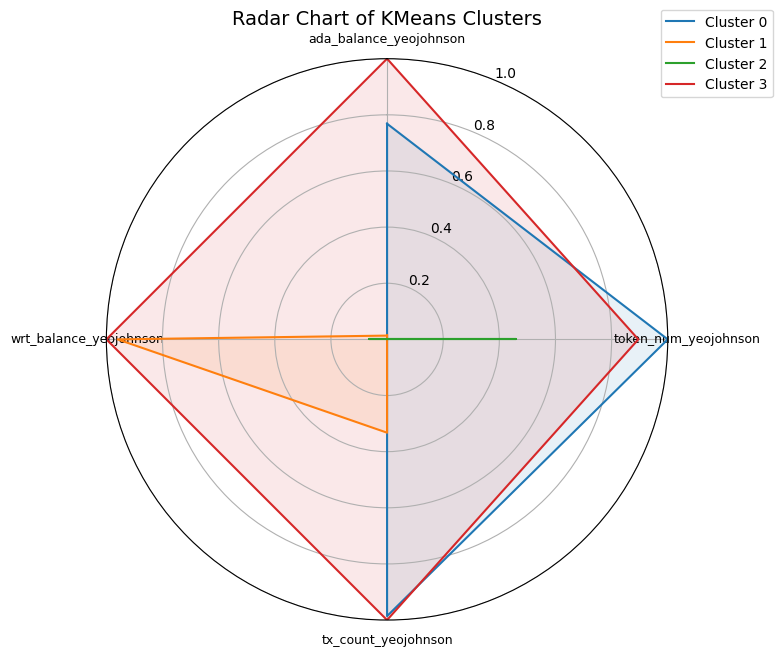

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Use updated feature list with Yeo-Johnson + raw count
# Step 2: Compute cluster-wise means
cluster_summary = wrt_aggregated_holder_df.groupby("kmeans_cluster")[features].mean()

# Step 3: Normalize each feature to [0, 1] for radar chart
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Step 4: Set up radar chart angles
num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Step 5: Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

# Step 6: Styling
ax.set_title("Radar Chart of KMeans Clusters", size=14)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Radar Chart of KMeans Clusters')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, 'ada_balance_yeojohnson'),
  Text(1.5707963267948966, 0, 'token_num_yeojohnson'),
  Text(3.141592653589793, 0, 'tx_count_yeojohnson'),
  Text(4.71238898038469, 0, 'wrt_balance_yeojohnson')])

(0.0, 1.0)

([<matplotlib.patches.Wedge at 0x7f585fb0f610>,
 [Text(-1.0724495393830726, -0.2446466543344409, 'Cluster 0'),
  Text(0.12053765058346708, -1.0933758158985494, 'Cluster 1'),
  Text(1.090662895899944, -0.1430190459594389, 'Cluster 2'),
  Text(0.017494741031520118, 1.0998608703087132, 'Cluster 3')],
 [Text(-0.5849724760271305, -0.13344362963696776, '29.4%'),
  Text(0.06574780940916385, -0.5963868086719359, '17.0%'),
  Text(0.5949070341272421, -0.07801038870514848, '25.4%'),
  Text(0.00954258601719279, 0.5999241110774799, '28.3%')])

Text(0.5, 1.0, 'Distribution of Holders per Cluster')

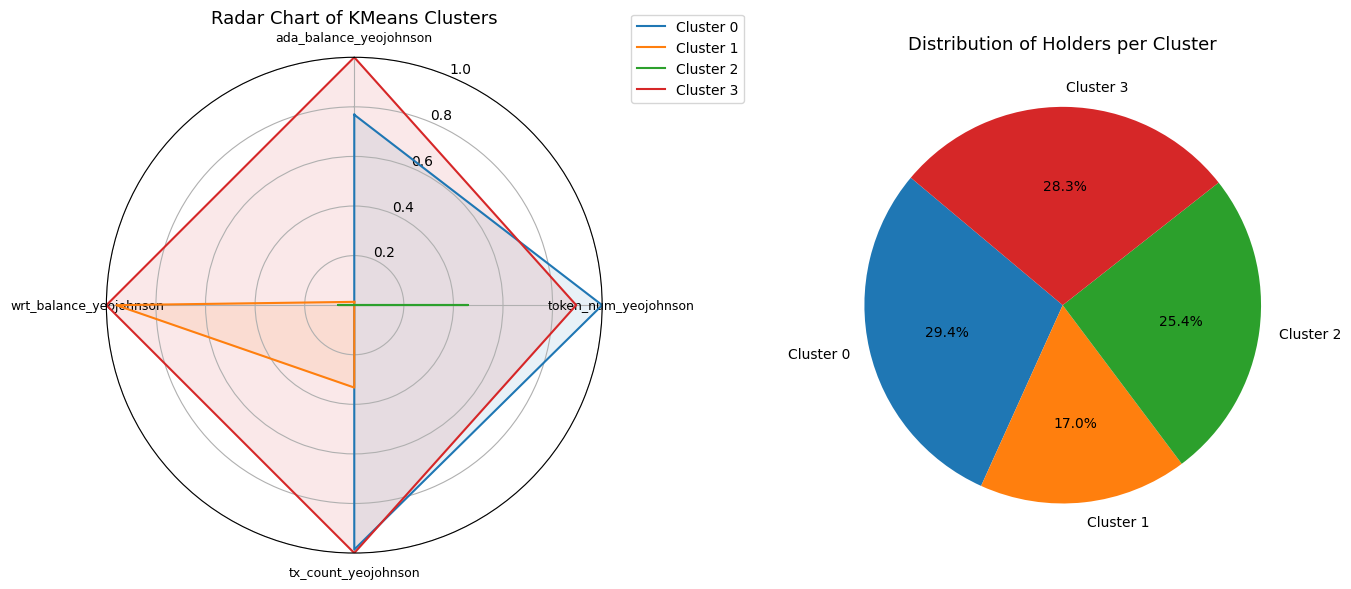

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Step 2: Cluster-wise means
cluster_summary = wrt_aggregated_holder_df.groupby("kmeans_cluster")[features].mean()

# Step 3: Normalize for radar chart
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Step 4: Cluster counts for pie chart
cluster_counts = wrt_aggregated_holder_df["kmeans_cluster"].value_counts().sort_index()
labels = [f"Cluster {i}" for i in cluster_counts.index]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Step 5: Plot setup
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

# Create subplots manually
fig = plt.figure(figsize=(14, 6))

# Radar chart (left)
ax1 = plt.subplot(1, 2, 1, polar=True)
for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist() + row.tolist()[:1]
    ax1.plot(angles, values, label=f"Cluster {idx}", color=colors[idx])
    ax1.fill(angles, values, alpha=0.1, color=colors[idx])

ax1.set_title("Radar Chart of KMeans Clusters", size=13)
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax1.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Pie chart (right)
ax2 = plt.subplot(1, 2, 2)
ax2.pie(cluster_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax2.set_title("Distribution of Holders per Cluster", fontsize=13)

plt.tight_layout()
plt.show()


Text(-0.05, 1345.5, 'Cluster 0')

Text(-0.05, 3464.0, 'Cluster 1')

Text(-0.05, 5400.5, 'Cluster 2')

Text(-0.05, 7850.5, 'Cluster 3')

Text(0.5, 1.0, 'Silhouette Analysis for KMeans Clustering (k=4)')

Text(0.5, 0, 'Silhouette Coefficient Values')

Text(0, 0.5, 'Cluster Label')

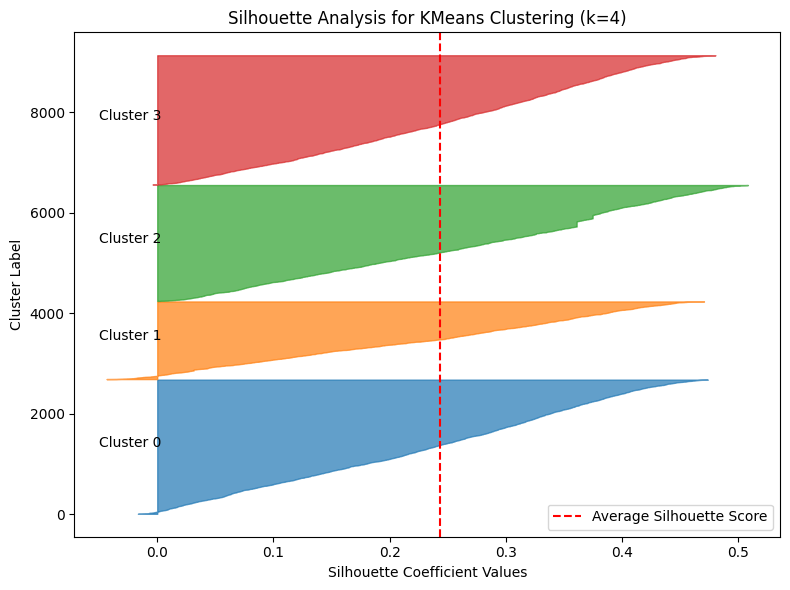

In [36]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Step 7: Compute silhouette values
cluster_labels = wrt_aggregated_holder_df["kmeans_cluster"]
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
avg_silhouette = silhouette_score(X_scaled, cluster_labels)

# Step 8: Plot Silhouette Analysis
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
n_clusters = len(np.unique(cluster_labels))

for i in range(n_clusters):
    ith_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_silhouette_values.sort()
    
    size_cluster_i = ith_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(i)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    
    y_lower = y_upper + 10  # Add space between clusters

# Step 9: Final formatting
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label="Average Silhouette Score")
ax.set_title(f"Silhouette Analysis for KMeans Clustering (k={n_clusters})")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()


In [37]:
wrt_balance_stats = wrt_aggregated_holder_df.groupby("kmeans_cluster")["wrt_balance"].describe()
wrt_balance_stats

,count,mean,std,min,25%,50%,75%,max
kmeans_cluster,,,,,,,,
0,2671.000000,3.967002,4.272088,1.000000,1.000000,2.000000,5.435288,27.004984
1,1546.000000,6711.921390,55596.102057,2.239034,29.790487,114.766010,600.000001,1369642.857013
2,2307.000000,6.078173,11.299005,1.000000,1.000000,3.000000,6.507584,150.829000
3,2573.000000,5395.467783,60643.766721,6.623843,40.349054,110.737539,694.238554,2249963.845241


Mean：

In [38]:
vars_to_avg = [
    "sent_sum_wrt", "received_sum_wrt",
    "sent_sum_ada", "received_sum_ada",
    "token_num", "ada_balance",
    "tx_count", "wrt_balance",
    "received_token_count", "sent_token_count"
]


cluster_means = wrt_aggregated_holder_df.groupby("kmeans_cluster")[vars_to_avg].mean()


cluster_means = cluster_means.round(2)


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

cluster_means


,sent_sum_wrt,received_sum_wrt,sent_sum_ada,received_sum_ada,token_num,ada_balance,tx_count,wrt_balance,received_token_count,sent_token_count
kmeans_cluster,,,,,,,,,,
0,2736.650000,2740.610000,1185237.030000,1196620.470000,167.820000,11397.780000,714.090000,3.970000,275.210000,243.490000
1,131683.650000,138395.570000,103910.020000,104690.360000,9.980000,780.200000,95.760000,6711.920000,20.700000,17.480000
2,583.720000,589.800000,22340.990000,22941.440000,36.110000,600.410000,34.170000,6.080000,43.040000,16.870000
3,1020190.110000,1025585.580000,2085049.530000,2118035.220000,168.270000,32995.460000,700.880000,5395.470000,246.840000,182.780000


Median：

In [39]:
vars_to_median = [
    "sent_sum_wrt", "received_sum_wrt",
    "sent_sum_ada", "received_sum_ada",
    "token_num", "ada_balance",
    "tx_count", "wrt_balance",
    "received_token_count", "sent_token_count"
]

# Calculate median instead of mean
cluster_medians = wrt_aggregated_holder_df.groupby("kmeans_cluster")[vars_to_median].median()

# Round to 2 decimals
cluster_medians = cluster_medians.round(2)

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

cluster_medians


,sent_sum_wrt,received_sum_wrt,sent_sum_ada,received_sum_ada,token_num,ada_balance,tx_count,wrt_balance,received_token_count,sent_token_count
kmeans_cluster,,,,,,,,,,
0,14.000000,17.000000,65496.890000,68859.090000,89.000000,332.320000,288.000000,2.000000,133.000000,109.000000
1,69.010000,408.420000,4297.940000,4640.280000,6.000000,17.790000,43.000000,114.770000,12.000000,9.000000
2,0.000000,5.300000,255.640000,472.750000,22.000000,17.070000,10.000000,3.000000,29.000000,0.000000
3,663.950000,1049.310000,112342.510000,119807.540000,72.000000,1106.070000,314.000000,110.740000,106.000000,88.000000


In [40]:
vars_std = [
    "sent_sum_wrt_yeojohnson", 
    "sent_sum_ada_yeojohnson", 
    "ada_balance_yeojohnson", 
    "token_num_yeojohnson",
    "tx_count_yeojohnson", 
    "wrt_balance_yeojohnson",
    "sent_token_count_yeojohnson"
]

cluster_means_std = wrt_aggregated_holder_df.groupby("kmeans_cluster")[vars_std].mean()

cluster_means_std = cluster_means_std.round(2)

cluster_means_std


,sent_sum_wrt_yeojohnson,sent_sum_ada_yeojohnson,ada_balance_yeojohnson,token_num_yeojohnson,tx_count_yeojohnson,wrt_balance_yeojohnson,sent_token_count_yeojohnson
kmeans_cluster,,,,,,,
0,2.190000,17.460000,4.450000,4.920000,7.300000,1.100000,5.460000
1,2.760000,11.380000,2.750000,2.060000,4.290000,2.840000,2.330000
2,0.720000,6.660000,2.720000,3.380000,2.760000,1.220000,1.720000
3,3.860000,18.910000,4.980000,4.620000,7.360000,2.910000,5.190000


In [41]:
vars_std = [
    "ada_balance_yeojohnson", 
    "token_num_yeojohnson",
    "wrt_balance_yeojohnson",
        "tx_count_yeojohnson"
]

cluster_means_std = wrt_aggregated_holder_df.groupby("kmeans_cluster")[vars_std].mean()

cluster_means_std = cluster_means_std.round(2)

cluster_means_std


,ada_balance_yeojohnson,token_num_yeojohnson,wrt_balance_yeojohnson,tx_count_yeojohnson
kmeans_cluster,,,,
0,4.450000,4.920000,1.100000,7.300000
1,2.750000,2.060000,2.840000,4.290000
2,2.720000,3.380000,1.220000,2.760000
3,4.980000,4.620000,2.910000,7.360000


In [42]:
from sklearn.preprocessing import StandardScaler

# Ensure same transformation as clustering
vars_std = [
    "ada_balance_yeojohnson", 
    "token_num_yeojohnson",
    "wrt_balance_yeojohnson",
    "tx_count_yeojohnson"
]


# 1. Apply the same standardization
scaler = StandardScaler()
scaled_vars = scaler.fit_transform(wrt_aggregated_holder_df[vars_std])

# 2. Create a DataFrame with standardized values
df_scaled = wrt_aggregated_holder_df.copy()
df_scaled[[f"{col}_std" for col in vars_std]] = scaled_vars

# 3. Calculate cluster means in standardized space
cluster_means_std = df_scaled.groupby("kmeans_cluster")[[f"{col}_std" for col in vars_std]].mean()
cluster_means_std = cluster_means_std.round(2)

cluster_means_std


,ada_balance_yeojohnson_std,token_num_yeojohnson_std,wrt_balance_yeojohnson_std,tx_count_yeojohnson_std
kmeans_cluster,,,,
0,0.380000,0.640000,-0.820000,0.580000
1,-0.730000,-1.260000,0.880000,-0.480000
2,-0.750000,-0.390000,-0.710000,-1.030000
3,0.720000,0.440000,0.960000,0.610000


In [43]:
from sklearn.preprocessing import MinMaxScaler
cluster_summary = wrt_aggregated_holder_df.groupby("kmeans_cluster")[features].mean().round(2)

scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

radar_table = cluster_scaled_df.round(2)
radar_table


,ada_balance_yeojohnson,token_num_yeojohnson,tx_count_yeojohnson,wrt_balance_yeojohnson
kmeans_cluster,,,,
0,0.770000,1.000000,0.990000,0.000000
1,0.010000,0.000000,0.330000,0.960000
2,0.000000,0.460000,0.000000,0.070000
3,1.000000,0.900000,1.000000,1.000000


In [44]:
from scipy.stats import f_oneway
import pandas as pd

f_stats = {}
p_values = {}

for feature in features:
    groups = [wrt_aggregated_holder_df[wrt_aggregated_holder_df['kmeans_cluster'] == c][feature] 
              for c in sorted(wrt_aggregated_holder_df['kmeans_cluster'].unique())]
    
    f_val, p_val = f_oneway(*groups)
    f_stats[feature] = f_val
    p_values[feature] = p_val

anova_df = pd.DataFrame({
    "F-statistic": f_stats,
    "p-value": p_values
}).round(4)

anova_df


,F-statistic,p-value
ada_balance_yeojohnson,2197.500600,0.000000
token_num_yeojohnson,2848.016500,0.000000
tx_count_yeojohnson,3169.585400,0.000000
wrt_balance_yeojohnson,7633.380700,0.000000


# HDBSCAN

In [45]:
!pip install hdbscan


In [46]:
import hdbscan
import pandas as pd
import numpy as np

results = []

# Define grid
min_cluster_sizes = [30, 50, 70, 100]
min_samples_list = [5, 10, 15, 20]

# Grid search
for mcs in min_cluster_sizes:
    for ms in min_samples_list:
        try:
            hdb = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
            labels = hdb.fit_predict(X_scaled)
            num_total = len(labels)
            num_noise = np.sum(labels == -1)
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = num_noise / num_total
            results.append({
                "min_cluster_size": mcs,
                "min_samples": ms,
                "num_clusters": num_clusters,
                "noise_points": num_noise,
                "noise_ratio": round(noise_ratio, 4)
            })
        except Exception as e:
            print(f"❌ Failed for mcs={mcs}, ms={ms}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="noise_ratio")

# Show best 10 results
results_df.head()


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11

,min_cluster_size,min_samples,num_clusters,noise_points,noise_ratio
0,30,5,16,7482,0.822500
4,50,5,9,7571,0.832300
12,100,5,7,7603,0.835800
8,70,5,8,7624,0.838100
14,100,15,4,7800,0.857400


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 HDBSCAN Clustering Result:
hdbscan_cluster
-1    7603
 0     116
 1     110
 2     398
 3     231
 4     213
 5     259
 6     167
Name: count, dtype: int64
❌ Noise points: 7603/9097 (83.58%)


Text(0.5, 1.0, 'Radar Chart of HDBSCAN Clusters')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, 'ada_balance_yeojohnson'),
  Text(1.5707963267948966, 0, 'token_num_yeojohnson'),
  Text(3.141592653589793, 0, 'tx_count_yeojohnson'),
  Text(4.71238898038469, 0, 'wrt_balance_yeojohnson')])

(0.0, 1.0)

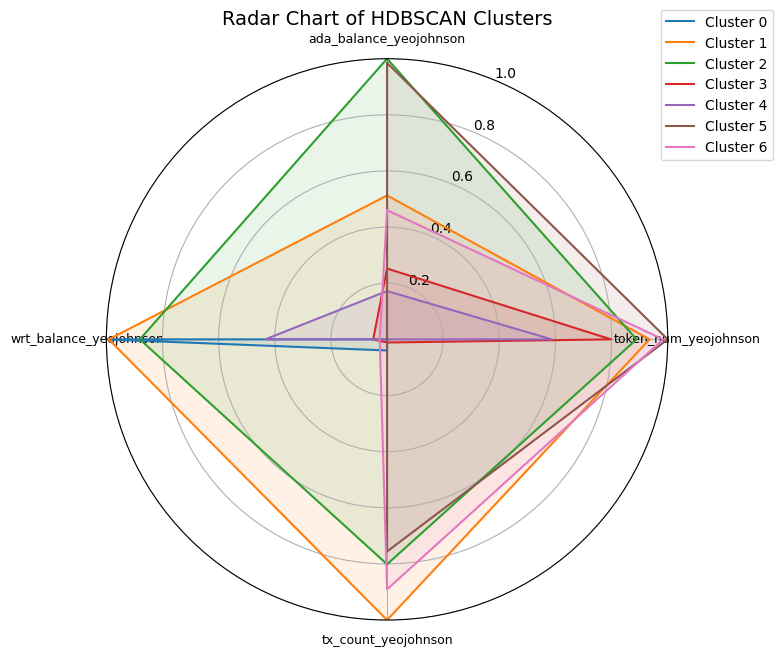

In [48]:
# Step 0: Install if needed
# !pip install hdbscan

import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# === Step 1: Run HDBSCAN ===
hdb = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=5)
hdb_labels = hdb.fit_predict(X_scaled)

# Save to df
wrt_aggregated_holder_df["hdbscan_cluster"] = hdb_labels

# Print label count
print("📊 HDBSCAN Clustering Result:")
print(wrt_aggregated_holder_df["hdbscan_cluster"].value_counts().sort_index())

# Print noise rate
noise_count = (hdb_labels == -1).sum()
total = len(hdb_labels)
print(f"❌ Noise points: {noise_count}/{total} ({noise_count/total:.2%})")

# === Step 2: Radar Chart of Cluster Means ===
features = [

    "ada_balance_yeojohnson", "token_num_yeojohnson",
    "tx_count_yeojohnson", "wrt_balance_yeojohnson",
]

# Filter out noise points
clustered_df = wrt_aggregated_holder_df[wrt_aggregated_holder_df["hdbscan_cluster"] != -1]

# Compute mean per cluster
cluster_summary = clustered_df.groupby("hdbscan_cluster")[features].mean()
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Radar plot
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

ax.set_title("Radar Chart of HDBSCAN Clusters", size=14)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

In [49]:
cluster_summary_table = clustered_df.groupby("hdbscan_cluster")[features].mean()
cluster_summary_table

,ada_balance_yeojohnson,token_num_yeojohnson,tx_count_yeojohnson,wrt_balance_yeojohnson
hdbscan_cluster,,,,
0,1.271845,0.893105,1.254061,2.845469
1,3.001133,4.422043,7.351270,2.826739
2,4.644134,4.247364,6.090206,2.582806
3,2.122805,3.904337,1.074060,0.750827
4,1.852455,3.108399,1.003176,1.598516
5,4.593108,4.666339,5.801039,0.642038
6,2.824171,4.604769,6.657153,0.699849


Text(-0.05, 68.0, 'Cluster 0')

Text(-0.05, 191.0, 'Cluster 1')

Text(-0.05, 455.0, 'Cluster 2')

Text(-0.05, 779.5, 'Cluster 3')

Text(-0.05, 1011.5, 'Cluster 4')

Text(-0.05, 1257.5, 'Cluster 5')

Text(-0.05, 1480.5, 'Cluster 6')

Text(0.5, 1.0, 'Silhouette Analysis for HDBSCAN Clustering (Excl. Noise)')

Text(0.5, 0, 'Silhouette Coefficient Values')

Text(0, 0.5, 'Cluster Label')

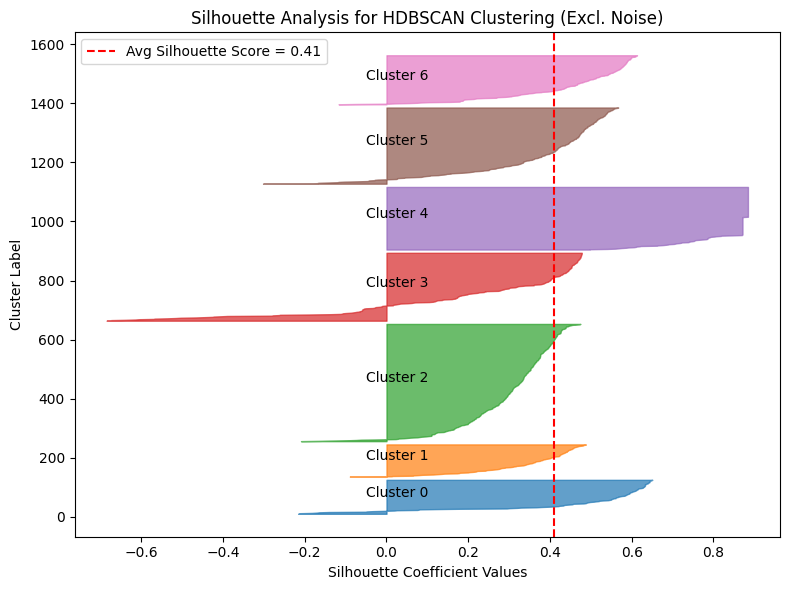

In [50]:
from sklearn.metrics import silhouette_samples, silhouette_score

# === Step 3: Silhouette Plot ===

# Filter X and labels to only clustered points (exclude noise)
X_clustered = X_scaled[wrt_aggregated_holder_df["hdbscan_cluster"] != -1]
labels_clustered = wrt_aggregated_holder_df.loc[wrt_aggregated_holder_df["hdbscan_cluster"] != -1, "hdbscan_cluster"]

# Compute silhouette values
sil_values = silhouette_samples(X_clustered, labels_clustered)
avg_sil = silhouette_score(X_clustered, labels_clustered)

# Start plotting
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
unique_clusters = np.sort(labels_clustered.unique())

for i in unique_clusters:
    ith_sil_vals = sil_values[labels_clustered == i]
    ith_sil_vals.sort()
    
    size = ith_sil_vals.shape[0]
    y_upper = y_lower + size

    color = plt.cm.tab10(i % 10)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size, f"Cluster {i}")
    y_lower = y_upper + 10

ax.axvline(x=avg_sil, color='red', linestyle='--', label=f"Avg Silhouette Score = {avg_sil:.2f}")
ax.set_title(f"Silhouette Analysis for HDBSCAN Clustering (Excl. Noise)")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()


In [51]:
# Step 4: Count the number of holders in each HDBSCAN cluster (excluding noise)

# Filter out noise points
non_noise_df = wrt_aggregated_holder_df[wrt_aggregated_holder_df["hdbscan_cluster"] != -1]

# Group by HDBSCAN cluster and count the number of unique holders
hdbscan_cluster_counts = non_noise_df.groupby("hdbscan_cluster")["final_holder_id"] \
    .nunique() \
    .reset_index(name="holder_count")

# Calculate total holders
total_holders = hdbscan_cluster_counts["holder_count"].sum()

# Add percentage column with % format
hdbscan_cluster_counts["percentage"] = hdbscan_cluster_counts["holder_count"] \
    .apply(lambda x: f"{(x / total_holders * 100):.2f}%")

# Sort by cluster ID
hdbscan_cluster_counts = hdbscan_cluster_counts.sort_values("hdbscan_cluster").reset_index(drop=True)

# Display the result
print("📦 Number and percentage of holders per HDBSCAN cluster:")
display(hdbscan_cluster_counts)


📦 Number and percentage of holders per HDBSCAN cluster:


,hdbscan_cluster,holder_count,percentage
0,0,116,7.76%
1,1,110,7.36%
2,2,398,26.64%
3,3,231,15.46%
4,4,213,14.26%
5,5,259,17.34%
6,6,167,11.18%


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='tsne_1', ylabel='tsne_2'>

Text(0.5, 1.0, 't-SNE Visualization of HDBSCAN Clusters')

Text(0.5, 0, 't-SNE Dimension 1')

Text(0, 0.5, 't-SNE Dimension 2')

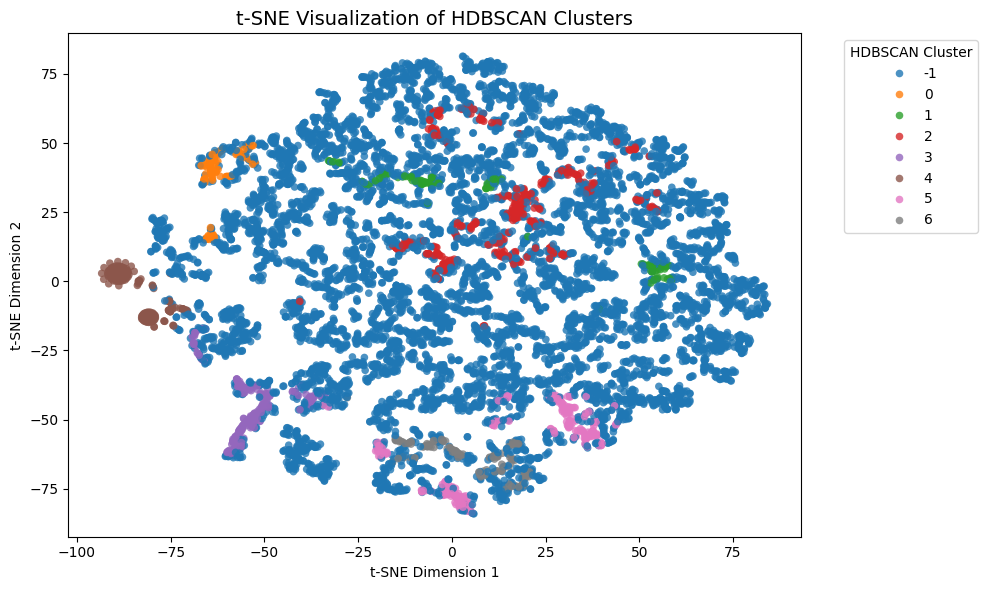

In [52]:
from sklearn.manifold import TSNE
import seaborn as sns

# Step 3: t-SNE visualization of HDBSCAN clusters

# Run t-SNE on the scaled data (you've already got X_scaled from earlier)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Add the t-SNE result to the original dataframe
wrt_aggregated_holder_df["tsne_1"] = X_tsne[:, 0]
wrt_aggregated_holder_df["tsne_2"] = X_tsne[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=wrt_aggregated_holder_df,
    x="tsne_1",
    y="tsne_2",
    hue="hdbscan_cluster",
    palette="tab10",
    linewidth=0,
    s=30,
    alpha=0.8,
    legend="full"
)
plt.title("t-SNE Visualization of HDBSCAN Clusters", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="HDBSCAN Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='tsne_1', ylabel='tsne_2'>

Text(0.5, 1.0, 't-SNE Visualization of HDBSCAN Clusters (Without Noise)')

Text(0.5, 0, 't-SNE Dimension 1')

Text(0, 0.5, 't-SNE Dimension 2')

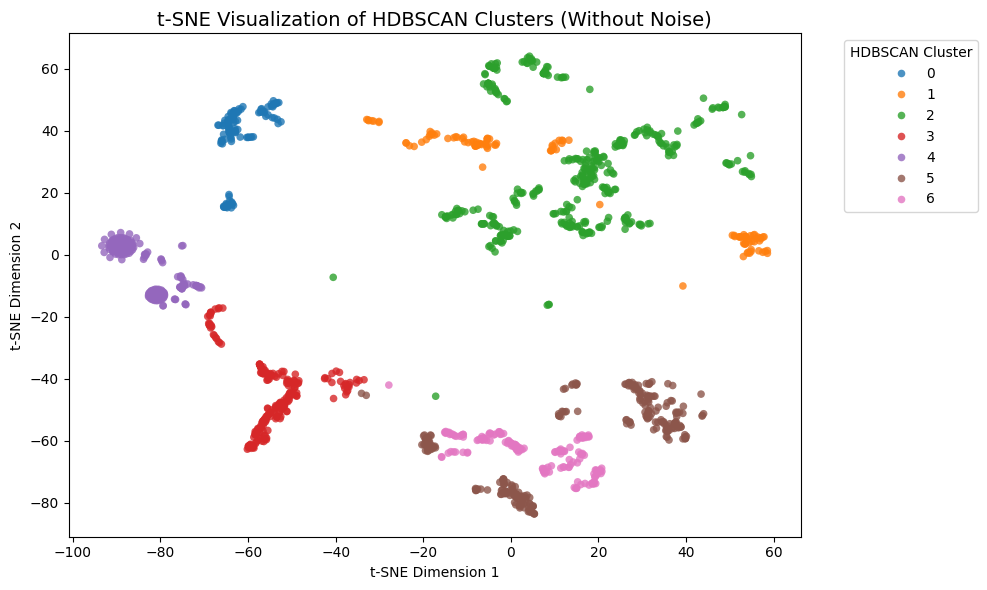

In [53]:
# filter out noises
filtered_df = wrt_aggregated_holder_df[wrt_aggregated_holder_df["hdbscan_cluster"] != -1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_df,
    x="tsne_1",
    y="tsne_2",
    hue="hdbscan_cluster",
    palette="tab10",
    linewidth=0,
    s=30,
    alpha=0.8,
    legend="full"
)
plt.title("t-SNE Visualization of HDBSCAN Clusters (Without Noise)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="HDBSCAN Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

<Figure size 700x500 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Gini Coefficient per HDBSCAN Cluster (wrt_balance)')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Gini Coefficient')

(0.0, 1.0)

([<matplotlib.axis.XTick at 0x7f587646c310>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

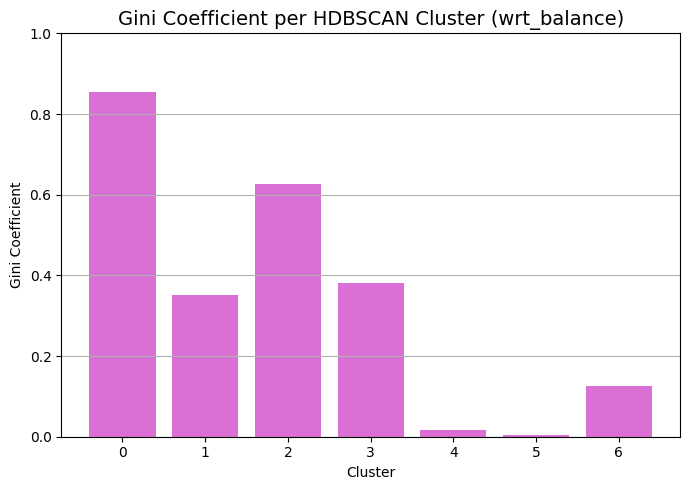

In [54]:
# === Step 3: Compute Gini coefficient for each cluster ===

def gini(array):
    """Compute Gini coefficient of a numpy array (ignoring NaNs)."""
    array = array[~np.isnan(array)]
    if len(array) == 0:
        return np.nan
    sorted_arr = np.sort(array)
    n = len(sorted_arr)
    cumvals = np.cumsum(sorted_arr)
    return (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n

# Choose target variable for inequality
gini_target = "wrt_balance"

# Compute Gini for each cluster (excluding noise)
gini_per_cluster = {}
for cluster_id in sorted(clustered_df["hdbscan_cluster"].unique()):
    values = clustered_df.loc[
        clustered_df["hdbscan_cluster"] == cluster_id, gini_target
    ].values
    gini_per_cluster[cluster_id] = gini(values)

# Plot Gini values
plt.figure(figsize=(7, 5))
plt.bar(gini_per_cluster.keys(), gini_per_cluster.values(), color="orchid")
plt.title(f"Gini Coefficient per HDBSCAN Cluster ({gini_target})", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Gini Coefficient")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.xticks(list(gini_per_cluster.keys()))
plt.tight_layout()
plt.show()


🔍 K-means cluster composition of HDBSCAN noise points:


,noise_count,percentage_of_noise
kmeans_cluster,,
0,2287,30.080000
1,1399,18.400000
2,1740,22.890000
3,2177,28.630000


<Figure size 800x400 with 0 Axes>

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


<Axes: xlabel='kmeans_cluster', ylabel='percentage_of_noise'>

Text(0.5, 1.0, 'HDBSCAN Noise Points: Original K-means Cluster Composition (%)')

Text(0.5, 0, 'K-means Cluster')

Text(0, 0.5, 'Percentage of Noise Points')

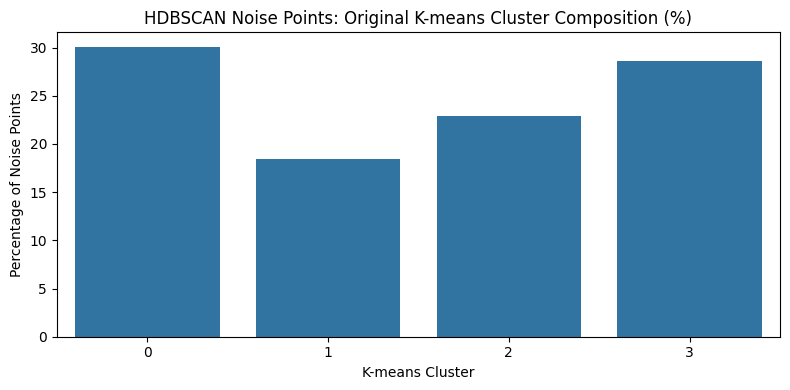

In [55]:
# Step 3: Analyze which k-means clusters the HDBSCAN noise points came from

# Filter out the noise points (label == -1 from HDBSCAN)
noise_df = wrt_aggregated_holder_df[wrt_aggregated_holder_df["hdbscan_cluster"] == -1]

# Count how many noise points were originally assigned to each k-means cluster
noise_kmeans_counts = noise_df["kmeans_cluster"].value_counts().sort_index()

# Calculate the percentage of noise points that came from each k-means cluster
noise_kmeans_percentage = (noise_kmeans_counts / len(noise_df)).round(4) * 100

# Combine into a single summary DataFrame
noise_kmeans_df = pd.DataFrame({
    "noise_count": noise_kmeans_counts,
    "percentage_of_noise": noise_kmeans_percentage
}).fillna(0).astype({"noise_count": "int"})

import seaborn as sns
import matplotlib.pyplot as plt

# Display the result
print("🔍 K-means cluster composition of HDBSCAN noise points:")
display(noise_kmeans_df)

# Optional: Bar chart visualization
plt.figure(figsize=(8, 4))
sns.barplot(data=noise_kmeans_df.reset_index(), x="kmeans_cluster", y="percentage_of_noise")
plt.title("HDBSCAN Noise Points: Original K-means Cluster Composition (%)")
plt.xlabel("K-means Cluster")
plt.ylabel("Percentage of Noise Points")
plt.tight_layout()
plt.show()


In [56]:
pd.crosstab(
    wrt_aggregated_holder_df["kmeans_cluster"],
    wrt_aggregated_holder_df["hdbscan_cluster"],
    rownames=["KMeans Cluster"],
    colnames=["HDBSCAN Cluster"],
    dropna=False  
)

HDBSCAN Cluster,-1,0,1,2,3,4,5,6
KMeans Cluster,,,,,,,,
0,2287,0,0,34,0,0,224,126
1,1399,98,32,17,0,0,0,0
2,1740,18,0,29,231,213,35,41
3,2177,0,78,318,0,0,0,0


# GMM


Text(0.5, 1.0, 'Silhouette Score vs. Number of Components (GMM)')

Text(0.5, 0, 'Number of Components (k)')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'BIC vs. Number of Components (GMM)')

Text(0.5, 0, 'Number of Components (k)')

Text(0, 0.5, 'BIC Score')

Text(0.5, 1.0, 'AIC vs. Number of Components (GMM)')

Text(0.5, 0, 'Number of Components (k)')

Text(0, 0.5, 'AIC Score')

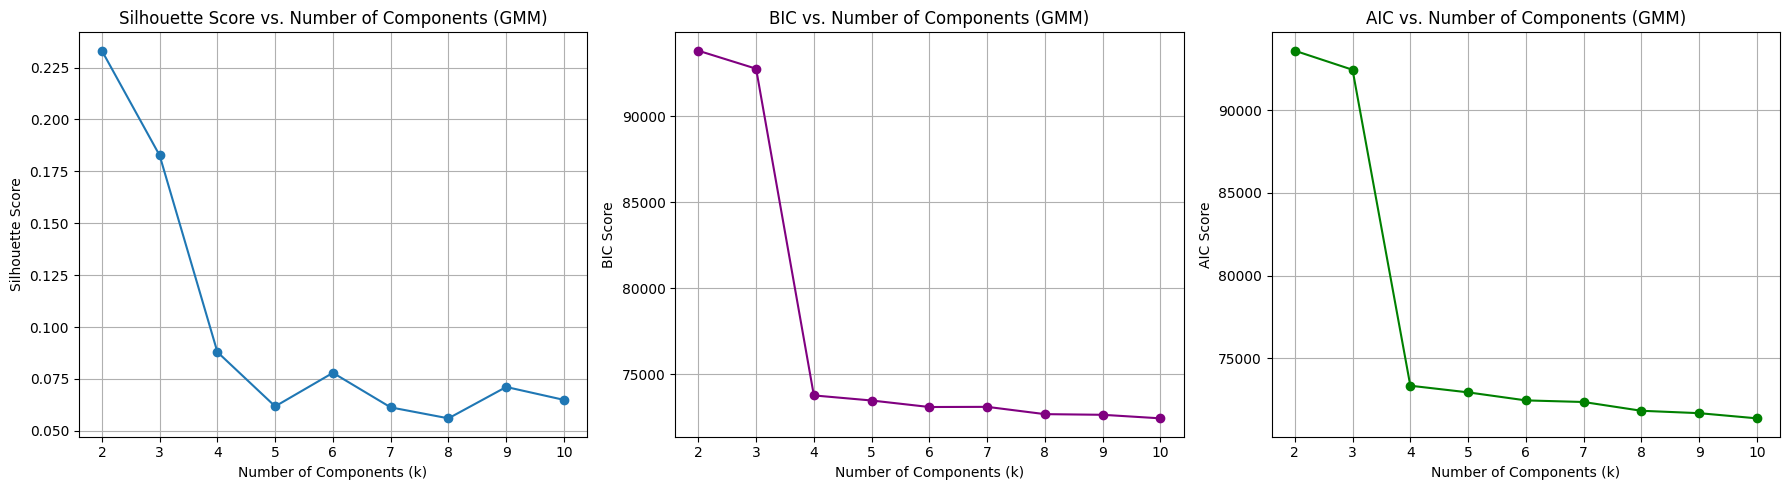

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Extract and standardize the selected features
X = wrt_aggregated_holder_df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Initialize result containers
silhouette_scores = []
bic_scores = []
aic_scores = []
k_range = range(2, 11)

# Step 3: Loop over possible k values to evaluate clustering quality
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)

    # Scores
    sil_score = silhouette_score(X_scaled, labels)
    bic_score = gmm.bic(X_scaled)
    aic_score = gmm.aic(X_scaled)

    silhouette_scores.append(sil_score)
    bic_scores.append(bic_score)
    aic_scores.append(aic_score)

# Step 4: Plot Silhouette, BIC, AIC side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score plot
ax1.plot(k_range, silhouette_scores, marker='o')
ax1.set_title("Silhouette Score vs. Number of Components (GMM)")
ax1.set_xlabel("Number of Components (k)")
ax1.set_ylabel("Silhouette Score")
ax1.grid(True)

# BIC plot (lower is better)
ax2.plot(k_range, bic_scores, marker='o', color='purple')
ax2.set_title("BIC vs. Number of Components (GMM)")
ax2.set_xlabel("Number of Components (k)")
ax2.set_ylabel("BIC Score")
ax2.grid(True)

# AIC plot (lower is better)
ax3.plot(k_range, aic_scores, marker='o', color='green')
ax3.set_title("AIC vs. Number of Components (GMM)")
ax3.set_xlabel("Number of Components (k)")
ax3.set_ylabel("AIC Score")
ax3.grid(True)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Radar Chart of GMM Clusters (k=4)')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, 'ada_balance_yeojohnson'),
  Text(1.5707963267948966, 0, 'token_num_yeojohnson'),
  Text(3.141592653589793, 0, 'tx_count_yeojohnson'),
  Text(4.71238898038469, 0, 'wrt_balance_yeojohnson')])

(0.0, 1.0)

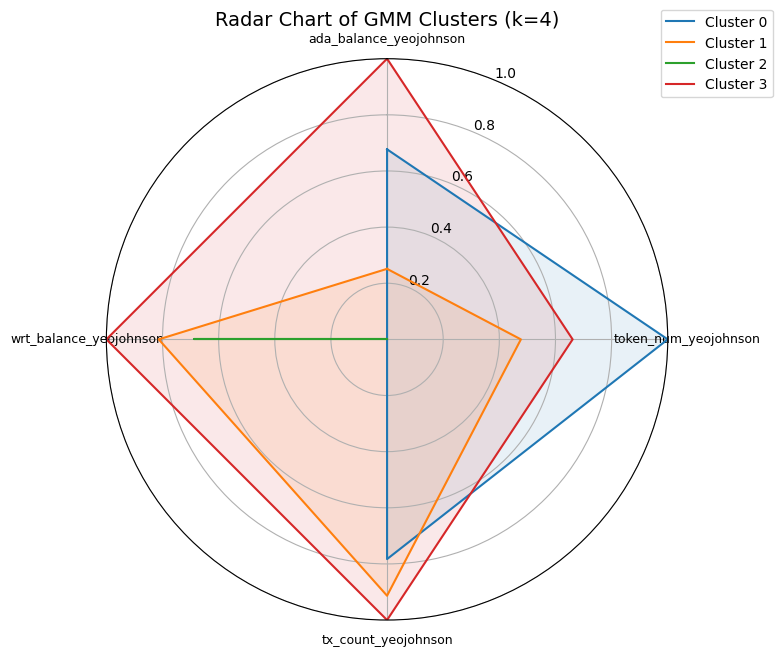

In [58]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fit GMM with k=4
gmm_final = GaussianMixture(n_components=4, random_state=42)
wrt_aggregated_holder_df["gmm_cluster"] = gmm_final.fit_predict(X_scaled)


cluster_summary = wrt_aggregated_holder_df.groupby("gmm_cluster")[features].mean()

# Step 3: Normalize values for radar plot
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Step 4: Radar chart
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

ax.set_title("Radar Chart of GMM Clusters (k=4)", size=14)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


Text(-0.05, 866.5, 'Cluster 0')

Text(-0.05, 3067.5, 'Cluster 1')

Text(-0.05, 4697.5, 'Cluster 2')

Text(-0.05, 7065.0, 'Cluster 3')

Text(0.5, 1.0, 'Silhouette Analysis for GMM Clustering (k=4)')

Text(0.5, 0, 'Silhouette Coefficient Values')

Text(0, 0.5, 'Cluster Label')

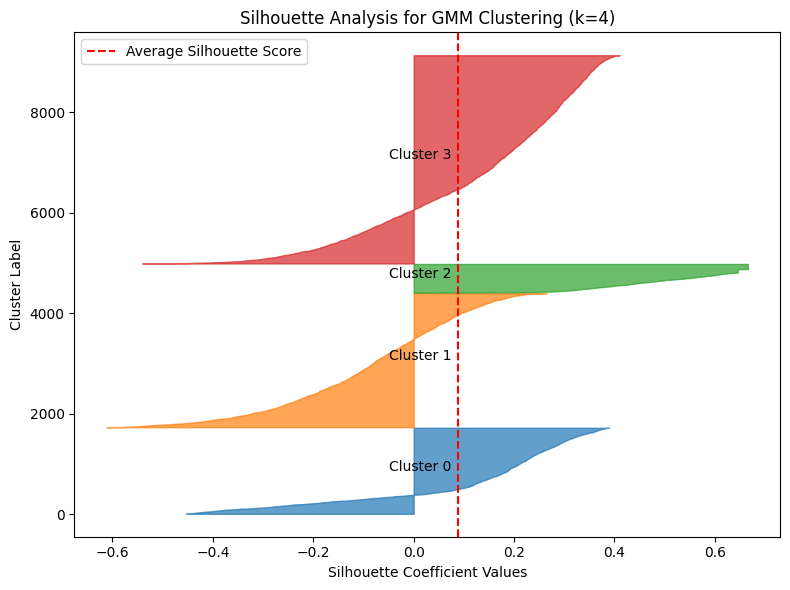

In [59]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Step 7: Compute silhouette values
cluster_labels = wrt_aggregated_holder_df["gmm_cluster"]  
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
avg_silhouette = silhouette_score(X_scaled, cluster_labels)

# Step 8: Plot Silhouette Analysis
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
n_clusters = len(np.unique(cluster_labels))

for i in range(n_clusters):
    ith_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_silhouette_values.sort()
    
    size_cluster_i = ith_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(i)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    
    y_lower = y_upper + 10

# Step 9: Final formatting
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label="Average Silhouette Score")
ax.set_title(f"Silhouette Analysis for GMM Clustering (k={n_clusters})") 
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()
